In [126]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
from AirSeaFluxCode import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
import scipy.stats as sstats
from matplotlib.ticker import ScalarFormatter

# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=24)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext

# Manually create Line2D objects for legend handles
legend_lines = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')]

# Manually create Line2D objects for legend handles
legend_dots = [
    Line2D([], [], color=c20, lw=0, marker='.', ms=25, label='SD1020'),
    Line2D([], [], color=c22, lw=0, marker='.', ms=25, label='SD1022'),
    Line2D([], [], color=c23, lw=0, marker='.', ms=25, label='SD1023')]

# Define a custom formatter function
def km_formatter(x, pos):
    return f'{x / 1:.0f} km'

def pc_formatter(x, pos):
    return f'{x:.0f}%'

colors = [c20, c22, c23]
labels = ["SD1020", "SD1022", "SD1023"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
ds20 = xr.open_dataset("../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc")\
        .squeeze().swap_dims({'obs':'time'})

adcp = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')\
        .squeeze().swap_dims({'obs':'time'})


In [128]:
import numpy as np

def calculate_direction(ds,vel_east, vel_north):
    # Calculate the angle of the velocity vector
    direction_rad = np.arctan2(adcp[vel_east], adcp[vel_north])
    
    # Convert radians to degrees and ensure values are between 0 and 360
    direction_deg = np.degrees(direction_rad) % 360
    
    return direction_deg

# Calculate directions
adcp['current_direction'] = calculate_direction(adcp,"vel_east", "vel_north")

In [129]:
# Calculate the angle of the current relative to the heading
adcp['current_angle'] = np.arctan2(adcp['vel_north'], adcp['vel_east']) - np.radians(adcp['heading'])
adcp['currents'] = (np.degrees(np.arctan2(adcp['vel_north'], adcp['vel_east'])) + 360) % 360

# Convert the angle to the range of -180 to 180 degrees
adcp['current_angle'] = np.degrees(adcp['current_angle'])
adcp['current_angle'] = (adcp['current_angle'] + 180) % 360 - 180

adcp['current_angle'] = adcp['current_angle'].sel(cell_depth=slice(0,20)).mean('cell_depth')
adcp['currents'] = ("time"), sstats.circmean(adcp['currents'].sel(cell_depth=slice(0,20)), axis=1, high=360)

In [130]:
def discrete_colors(cmap_name, num_colors):
    return plt.get_cmap(cmap_name, num_colors)(range(num_colors))

# Example usage:
colors = discrete_colors('cmo.dense_r', len(adcp["cell_depth"]))

In [190]:
np.mean(colors,axis=0)

array([0.49548479, 0.46104354, 0.69644964, 1.        ])

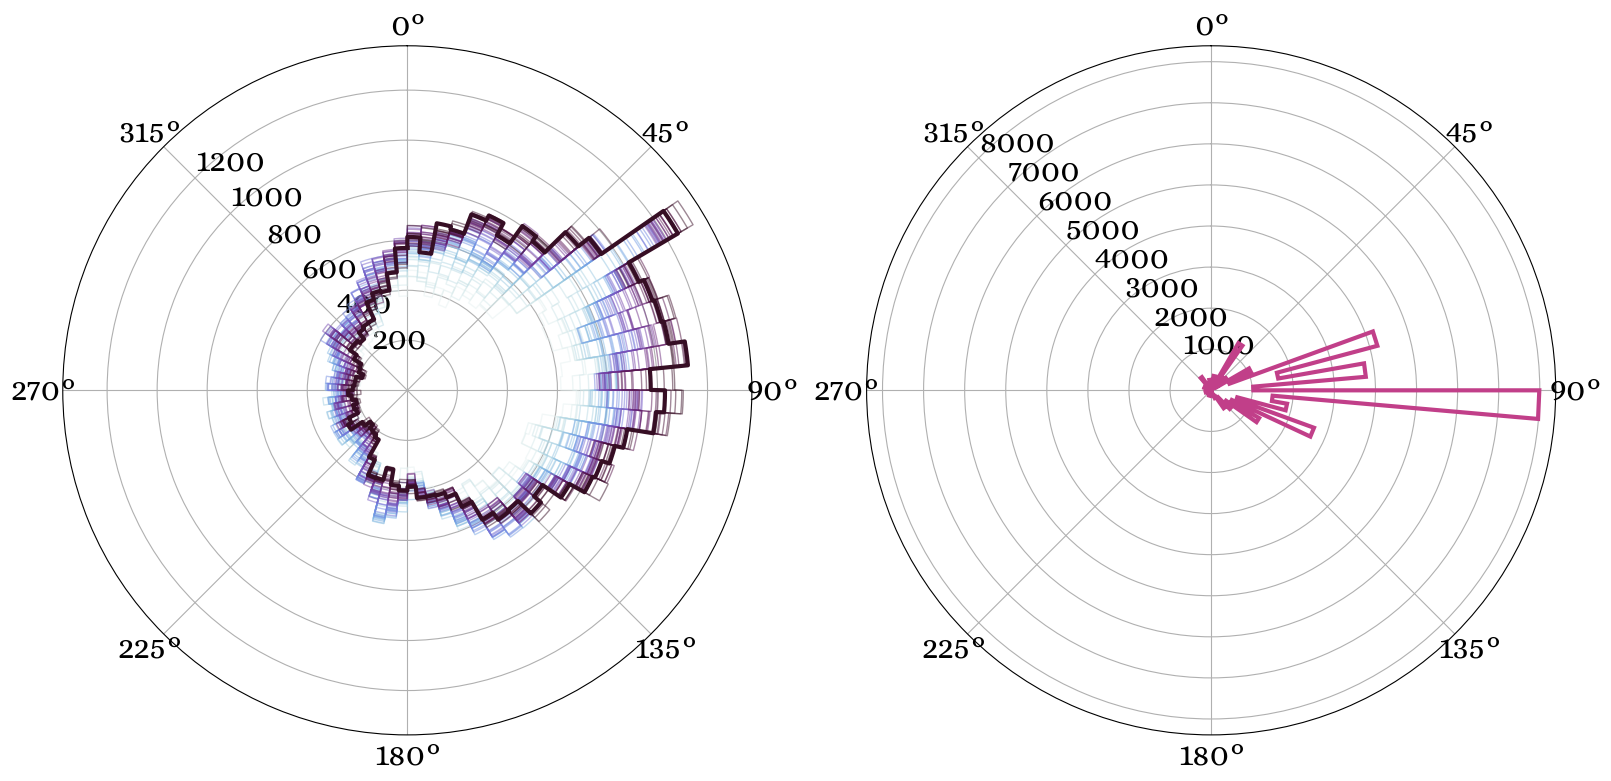

In [131]:
fig,ax = plt.subplots(1,2,figsize=(16,8),constrained_layout=True,subplot_kw={"polar":True},)


for d,c in zip(adcp["cell_depth"][::-1],colors[::-1]):
    bins = np.arange(0, 361, 5)

    h = np.histogram(np.deg2rad(adcp['current_direction'].sel(cell_depth=d)),bins=np.deg2rad(bins))

    counts = np.insert(np.repeat(h[0],2),0,h[0][-1])
    bins = np.repeat(bins,2)[:-1]


    smooth_bins   = np.insert(np.interp(np.arange(0,361,0.1),bins,bins),0,bins[-1])
    smooth_counts = np.insert(np.interp(np.arange(0,361,0.1),bins,counts),0,counts[-1])
    
    ax[0].plot(np.deg2rad(smooth_bins),smooth_counts,lw=1,c=c,alpha=0.5)


bins = np.arange(0, 361, 5)

h = np.histogram(sstats.circmean(np.deg2rad(adcp['current_direction'].sel(cell_depth=slice(0,20))),axis=1),bins=np.deg2rad(bins))

counts = np.insert(np.repeat(h[0],2),0,h[0][-1])
bins = np.repeat(bins,2)[:-1]


smooth_bins   = np.insert(np.interp(np.arange(0,361,0.1),bins,bins),0,bins[-1])
smooth_counts = np.insert(np.interp(np.arange(0,361,0.1),bins,counts),0,counts[-1])
    
ax[0].plot(np.deg2rad(smooth_bins),smooth_counts,lw=3,c=c,alpha=1)


_=ax[1].hist(np.deg2rad(adcp['heading']),bins=np.deg2rad(np.arange(0,361,5)),
          histtype="step",
          ec=c20, alpha=1,lw=3)

for axs in ax:
    axs.set_theta_zero_location('N')
    axs.set_theta_direction(-1)  # Clockwise rotation, use 1 for counterclockwise
    axs.set_rlabel_position(-45)  # Move radial labels away from plotted line

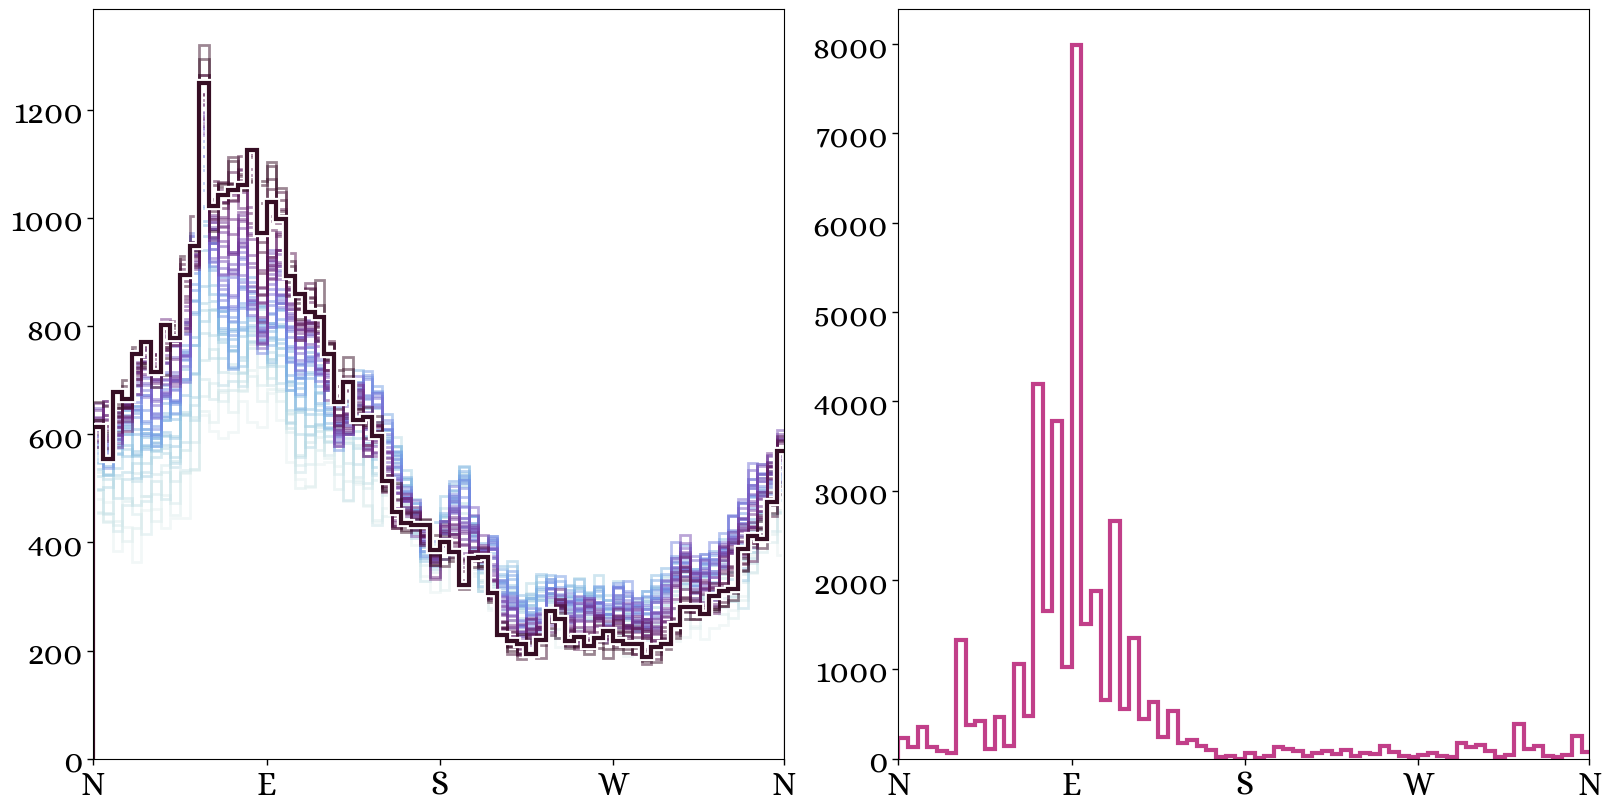

In [135]:
fig,ax = plt.subplots(1,2,figsize=(16,8),constrained_layout=True)


for d,c in zip(adcp["cell_depth"][::-1],colors[::-1]):
    
    bins = np.arange(0, 361, 5)

    _=ax[0].hist(np.deg2rad(adcp['current_direction'].sel(cell_depth=d)),bins=np.deg2rad(np.arange(0,361,5)),
          histtype="step",
          ec=c, lw=2,alpha=0.5)


ax[0].hist(sstats.circmean(np.deg2rad(adcp['current_direction'].sel(cell_depth=slice(0,20))),axis=1),bins=np.deg2rad(bins),ec="w",histtype="step",lw=6)
ax[0].hist(sstats.circmean(np.deg2rad(adcp['current_direction'].sel(cell_depth=slice(0,20))),axis=1),bins=np.deg2rad(bins),ec=c,histtype="step",lw=3)

_=ax[1].hist(np.deg2rad(adcp['heading']),bins=np.deg2rad(np.arange(0,361,5)),
          histtype="step",
          ec=c20, alpha=1,lw=3)

for axs in ax:
    axs.set(xlim=(0,np.pi*2-np.pi/180))
    axs.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi-np.pi/180],labels=["N","E","S","W","N"])

plt.show()

In [157]:
interval.stop

AttributeError: 'str' object has no attribute 'str'

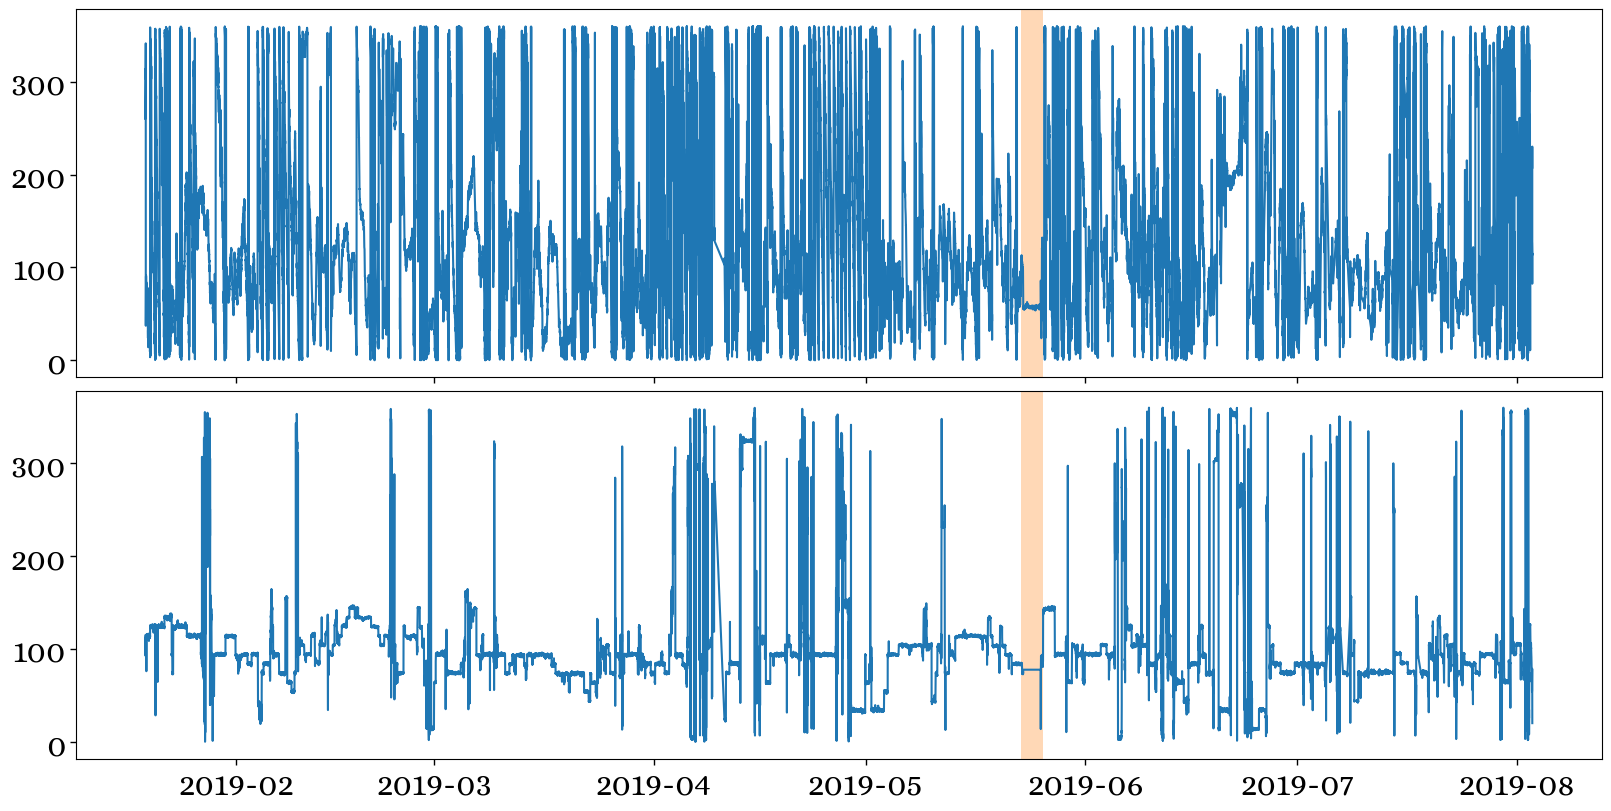

In [169]:
fig,ax = plt.subplots(2,1,figsize=(16,8),constrained_layout=True, sharex=True)

ax[0].plot(adcp['time'],sstats.circmean((adcp['current_direction'].sel(cell_depth=slice(0,20))),axis=1,high=360))
ax[1].plot(adcp['time'],adcp["heading"])

shaded_region = True
interval = slice("2019-05-23","2019-05-26")

if shaded_region:
    for axs in ax:
        ylim = axs.get_ylim()
        axs.fill([np.datetime64(interval.start),
                  np.datetime64(interval.stop),
                  np.datetime64(interval.stop),
                  np.datetime64(interval.start),
                  np.datetime64(interval.start)],
                 [ylim[0],
                  ylim[0], 
                  ylim[1], 
                  ylim[1], 
                  ylim[0]], 'C1', alpha=0.3)
        
        axs.set_ylim(ylim)

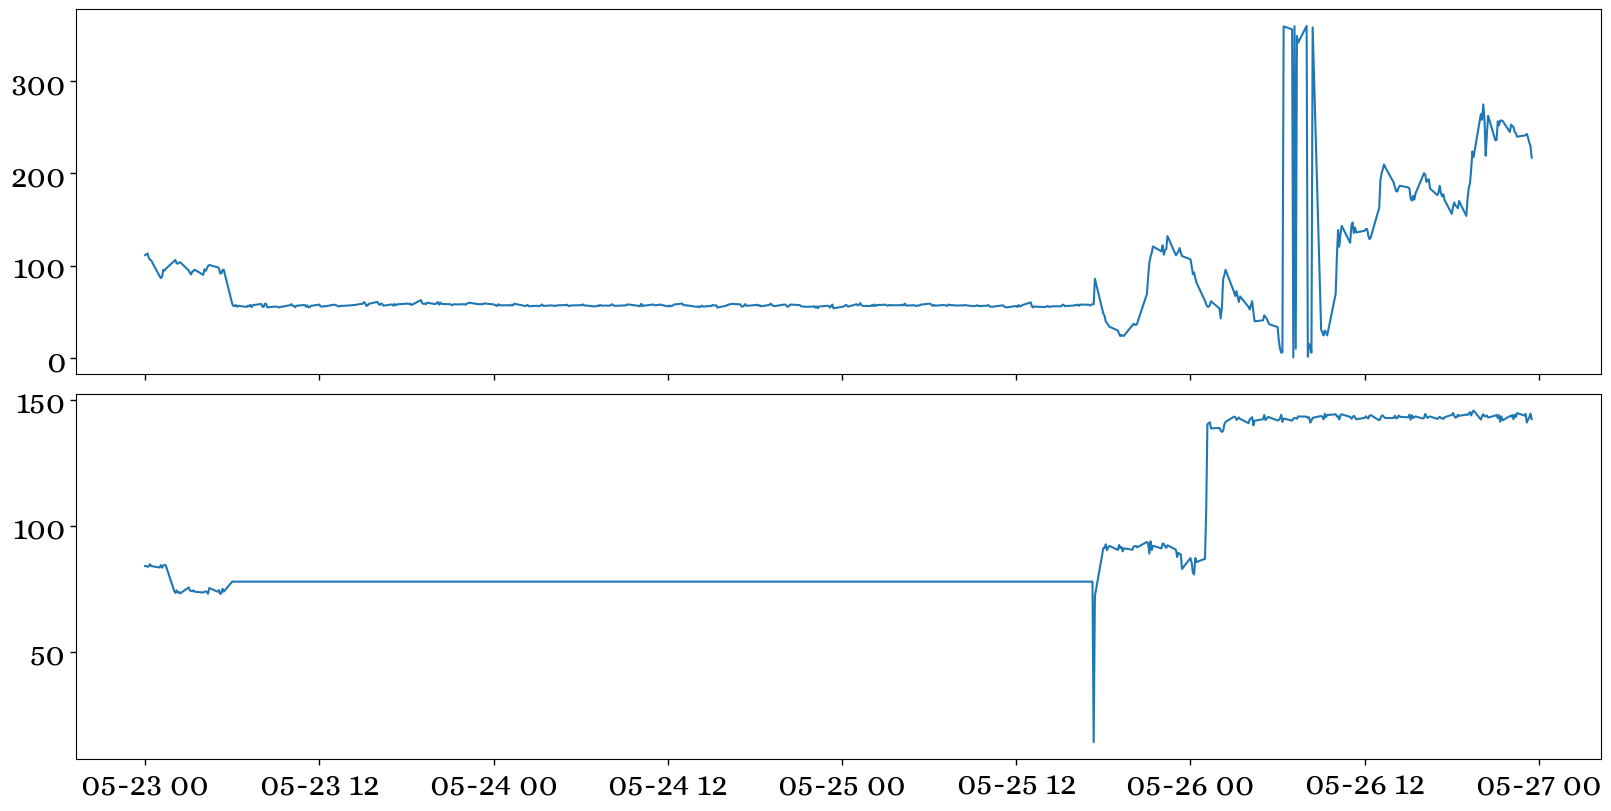

In [177]:
fig,ax = plt.subplots(2,1,figsize=(16,8),constrained_layout=True, sharex=True)

ax[0].plot(adcp['time'].sel(time=interval),sstats.circmean((adcp['current_direction'].sel(cell_depth=slice(0,20))).sel(time=interval),axis=1,high=360))
ax[1].plot(adcp['time'].sel(time=interval),adcp["heading"].sel(time=interval),marker='')


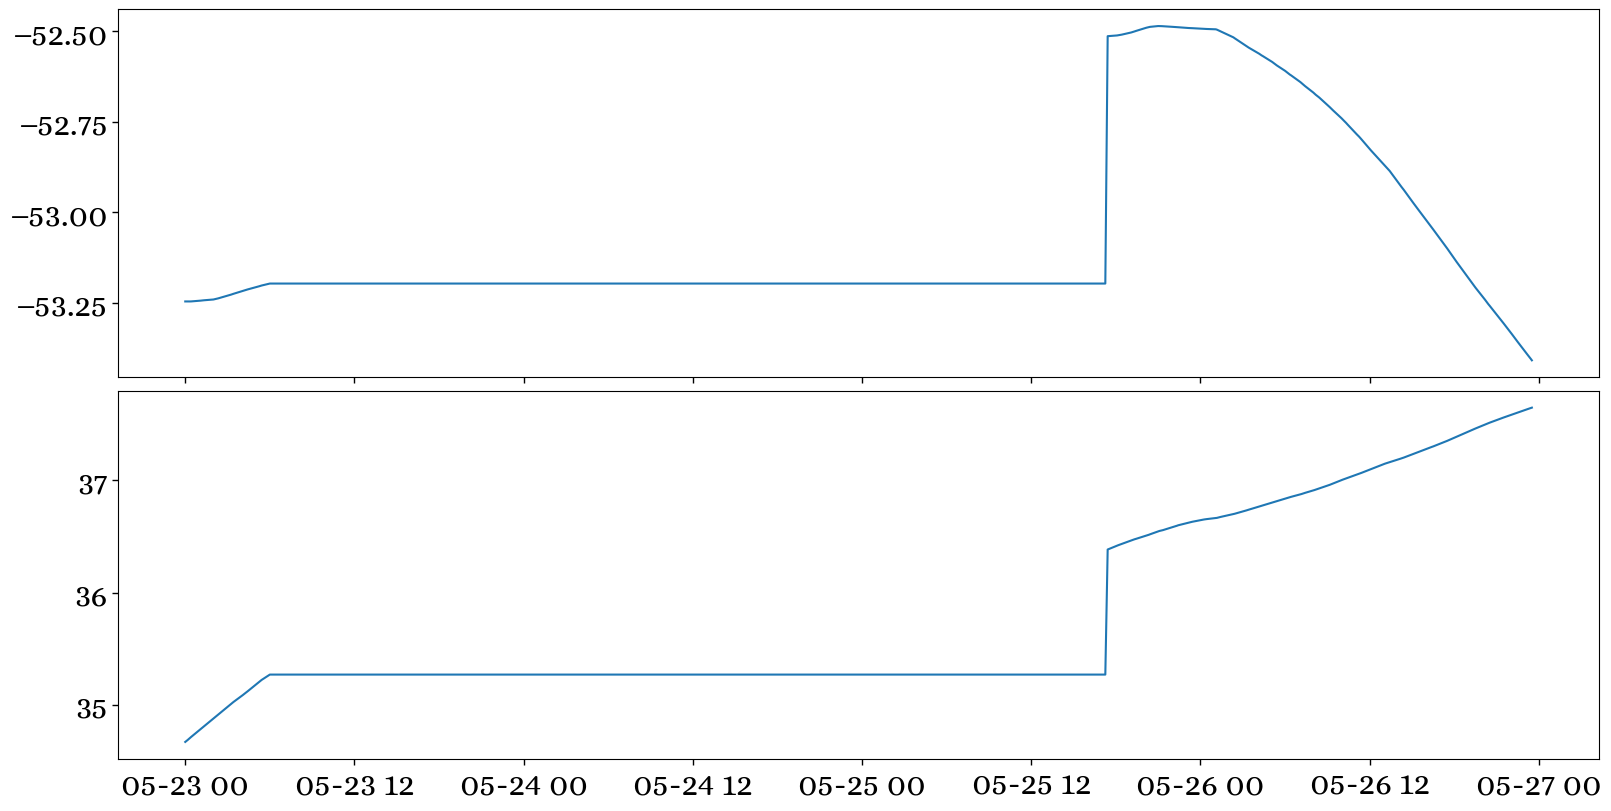

In [190]:
fig,ax = plt.subplots(2,1,figsize=(16,8),constrained_layout=True, sharex=True)

ax[0].plot(adcp['time'].sel(time=interval),adcp["latitude"].sel(time=interval))

ax[1].plot(adcp['time'].sel(time=interval),adcp["longitude"].sel(time=interval))

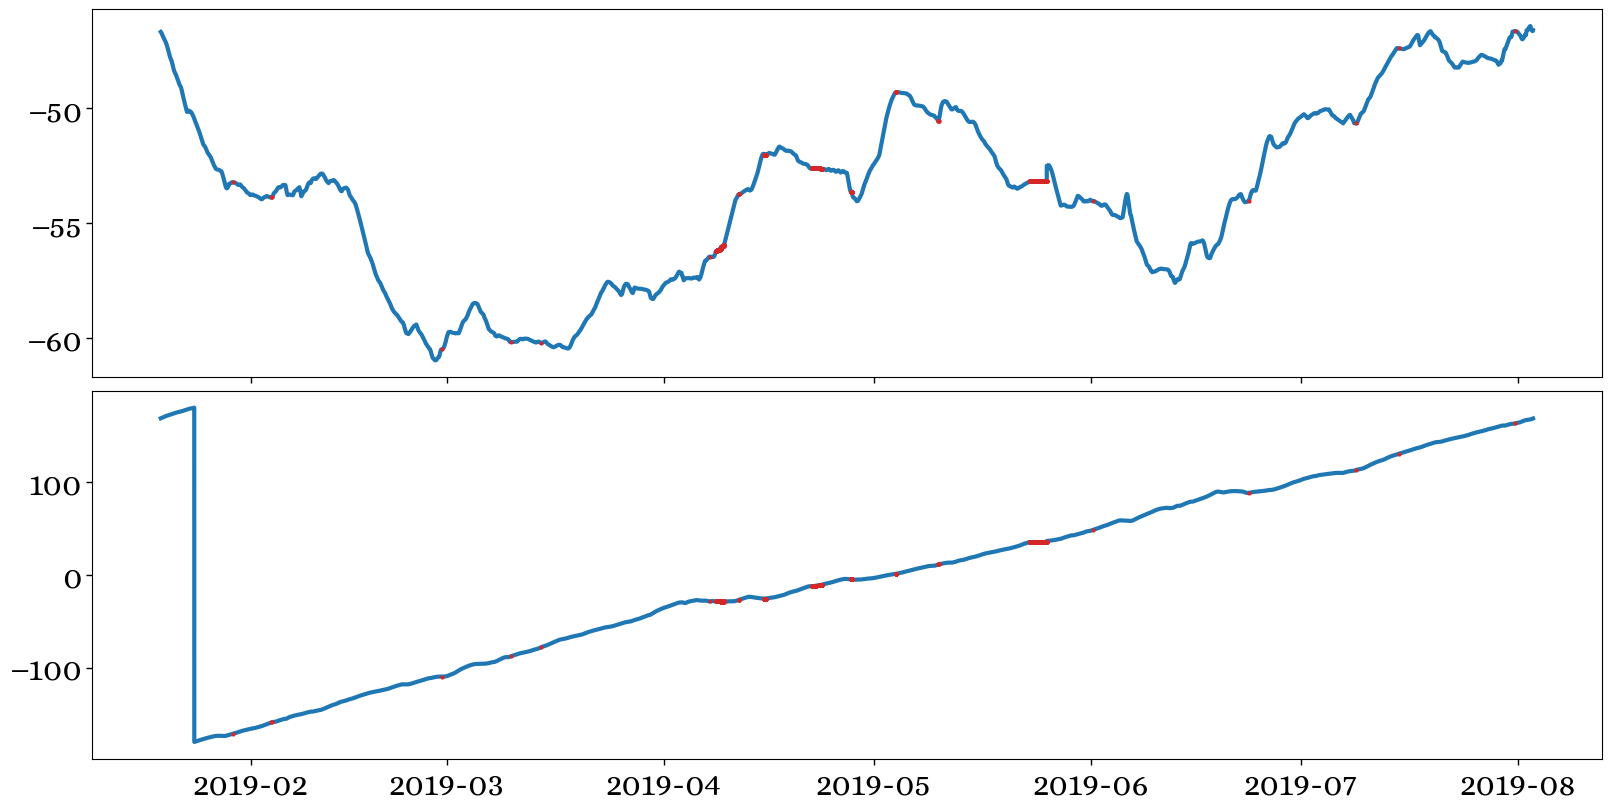

In [208]:
fig,ax = plt.subplots(2,1,figsize=(16,8),constrained_layout=True, sharex=True)

mask = np.logical_or(adcp["latitude"].diff("time") == 0, adcp["longitude"].diff("time") == 0)

ax[0].plot(adcp['time'],adcp["latitude"],lw=3)
ax[0].plot(adcp['time'].where(mask),adcp["latitude"].where(mask),marker='.',mfc="C3",mew=0)
                                                 

ax[1].plot(adcp['time'],adcp["longitude"],lw=3)
ax[1].plot(adcp['time'].where(mask),adcp["longitude"].where(mask),marker='.',mfc="C3",mew=0)
                

In [200]:
gsw.distance([adcp["longitude"][0],adcp["longitude"][0]+0.0000005],[adcp["latitude"][0],adcp["latitude"][0]])

array([0.03814164])

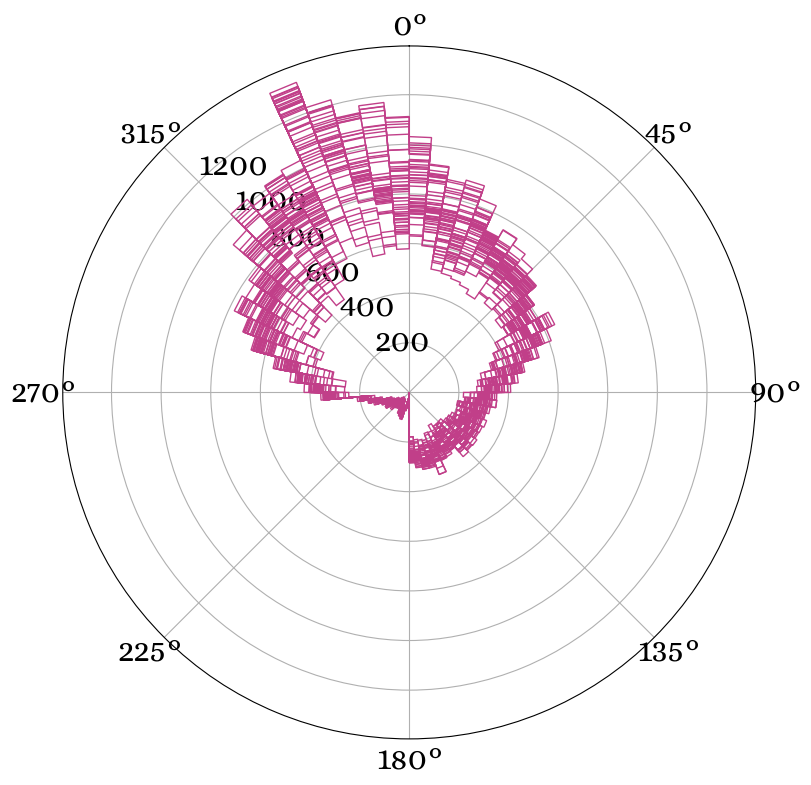

In [172]:
fig,ax = plt.subplots(figsize=(8,8),constrained_layout=True,subplot_kw={"polar":True},)

_=ax.hist(np.deg2rad(adcp['current_direction'])-np.deg2rad(adcp['heading']),bins=np.deg2rad(np.arange(-180,181,5)),
          histtype="step",
          ec=c20, alpha=1)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise rotation, use 1 for counterclockwise
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line
fig.savefig('temp.png', transparent=True)

In [132]:
np.abs(np.deg2rad((adcp['current_direction']+180)%360-180).isel(cell_depth=0))

<xarray.DataArray 'current_direction' (time: 38105)>
array([1.56737168, 1.61862307, 1.60241229, ..., 2.32394761, 2.49108465,
       2.57804561])
Coordinates:
    trajectory  float32 1.02e+03
    cell_depth  float64 4.2
  * time        (time) datetime64[ns] 2019-01-19T04:00:00 ... 2019-08-03T04:2...
    latitude    (time) float64 ...
    longitude   (time) float64 ...

In [141]:
90-(88-90)%90

2

In [147]:
np.where(cabs>90)

(array([], dtype=int64),)

In [148]:
cabs

array([1.56737168, 1.61862307, 1.60241229, ..., 2.32394761, 2.49108465,
       2.57804561])

In [150]:
cabs = np.abs(np.deg2rad((adcp['current_direction']+180)%360-180).isel(cell_depth=0)).values

cabsq1 = cabs.copy()
cabsq1[cabsq1>np.pi/2] = (np.pi/2)-(cabsq1[cabsq1>np.pi/2]-(np.pi/2))%(np.pi/2)

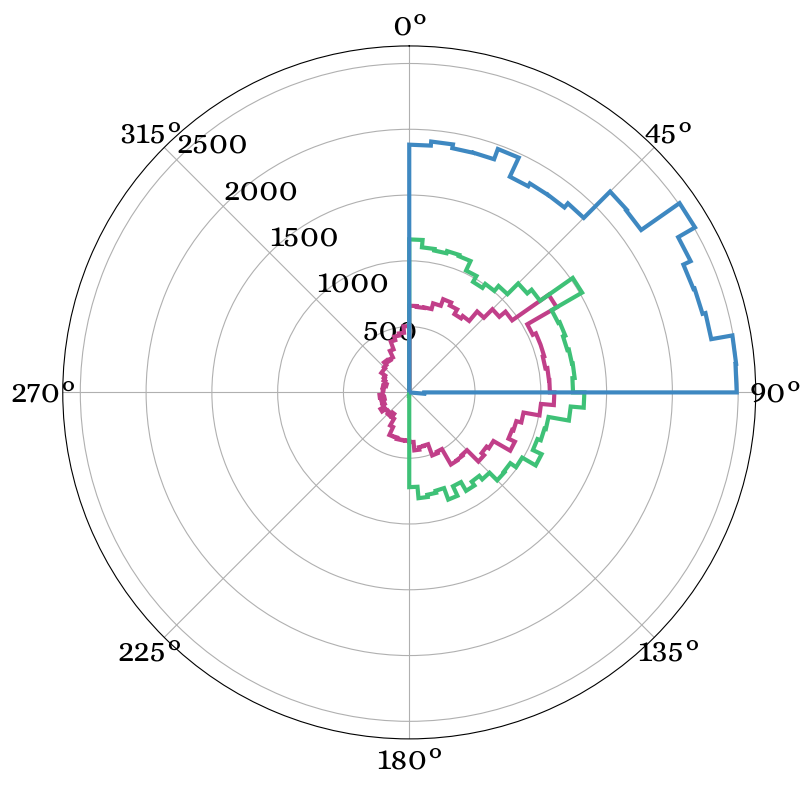

In [151]:
fig,ax = plt.subplots(figsize=(8,8),constrained_layout=True,subplot_kw={"polar":True},)

_=ax.hist(np.deg2rad(adcp['current_direction'].isel(cell_depth=0)),bins=np.deg2rad(np.arange(0,361,5)),
          histtype="step",
          ec=c20, lw=3)

_=ax.hist(cabs,bins=np.deg2rad(np.arange(-180,361,5)),
          histtype="step",
          ec=c22, lw=3)

_=ax.hist(cabsq1,bins=np.deg2rad(np.arange(-180,361,5)),
          histtype="step",
          ec=c23, lw=3)


ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise rotation, use 1 for counterclockwise
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line


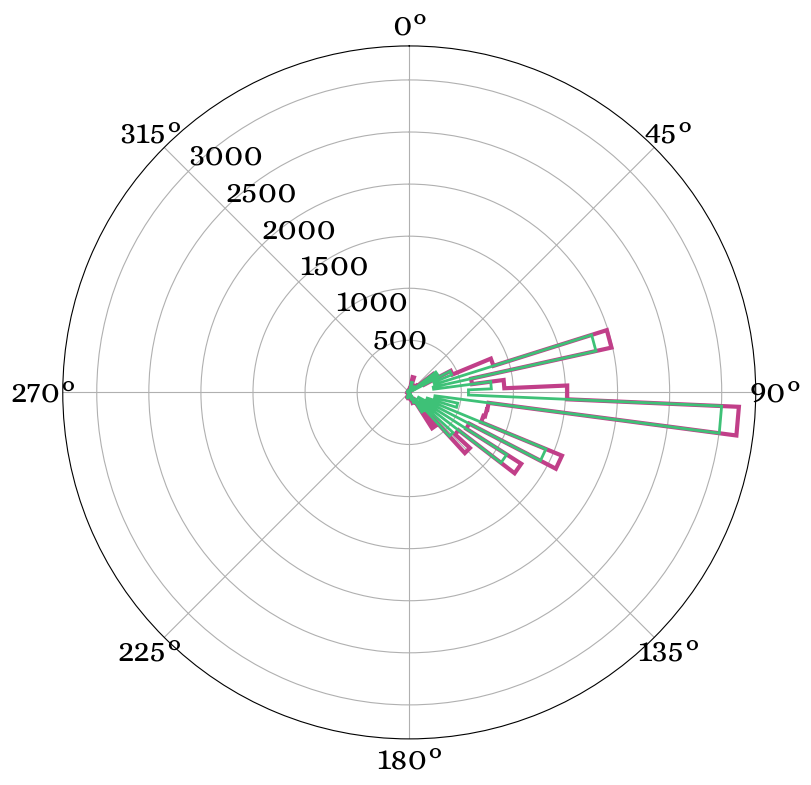

In [119]:
fig,ax = plt.subplots(figsize=(8,8),constrained_layout=True,subplot_kw={"polar":True})

_=ax.hist(np.deg2rad(ds20['HDG']),bins=np.deg2rad(np.arange(-2.5,363,5)),
          histtype="step",
          ec=c20, lw=3)

_=ax.hist(np.deg2rad(adcp.sel(time=slice('2019-01-19T04:00:00',
                                         '2019-03-26T13:45:00'))['heading']),bins=np.deg2rad(np.arange(-2.5,363,5)),
          histtype="step",
          ec=c22, lw=2)

#_=ax.hist(np.deg2rad(ds20['HDG']),bins=np.deg2rad(np.arange(0,361,5)),
#          histtype="step",
#          ec=c22, lw=2)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise rotation, use 1 for counterclockwise
ax.set_rlabel_position(-45)  # Move radial labels away from plotted line

In [152]:
# Set the frontal crossing angle to be the same as the current angle
adcp['frontal_crossing_angle'] = adcp['current_angle']

# Calculate the absolute value of the frontal crossing angles
adcp['absolute_frontal_crossing_angle'] = np.abs(adcp['frontal_crossing_angle'])

# Calculate the perpendicular crossing angle by taking the absolute value of the frontal crossing angle, subtracting 90 degrees, and then taking the absolute value again
perpendicular_crossing_angle = np.abs(np.abs(adcp['frontal_crossing_angle']) - 90)

# Get statistics from the perpendicular crossing angles
mean_angle = perpendicular_crossing_angle.mean().values
median_angle = np.median(perpendicular_crossing_angle.values)
std_dev_angle = perpendicular_crossing_angle.std().values
# You can calculate more statistics as needed

# Now, mean_angle, median_angle, std_dev_angle contain the mean, median, and standard deviation of the perpendicular crossing angles,
# which properly considers the angles' relationship to perpendicularity.
print(f"Mean: {mean_angle}")
print(f"Median: {median_angle}")
print(f"Standard deviation: {std_dev_angle}")

Mean: 42.010133164384875
Median: 41.46427970627357
Standard deviation: 25.368205209116304


In [15]:
def reg_fig():
    fig,ax = plt.subplots(figsize=(16,8),constrained_layout=True)
    return fig, ax 


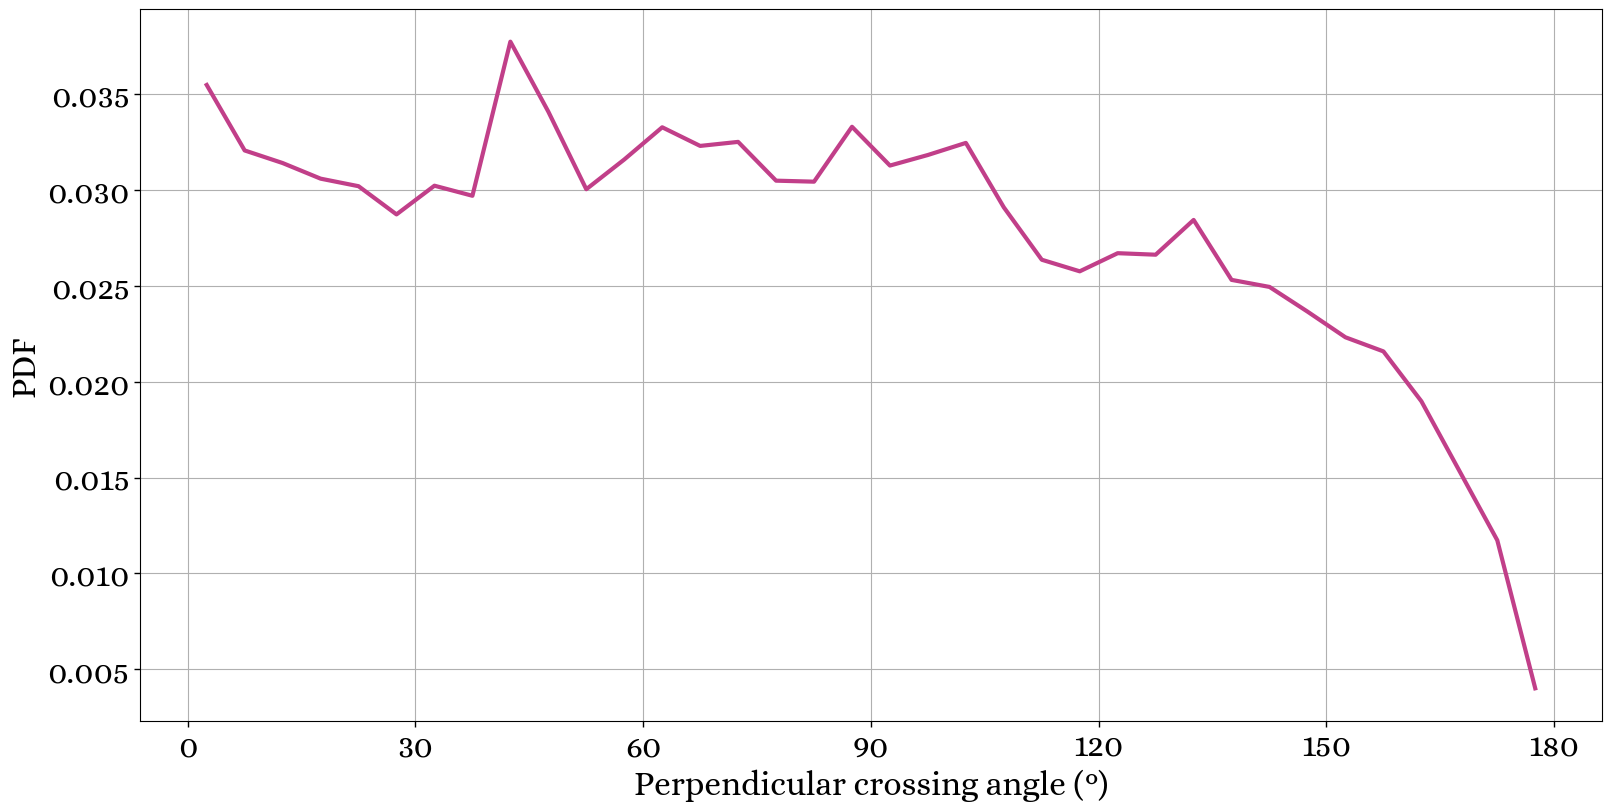

In [10]:
fig,ax = reg_fig()

h = np.histogram(np.abs(adcp['current_angle']),bins=np.arange(0,181,5))

ax.plot(np.arange(2.5,181,5).round(1),h[0]/h[0].sum(),c=c20,lw=3)
ax.set(xticks=np.arange(0,181,30),ylabel="PDF",xlabel="Perpendicular crossing angle (°)")
#ax.xaxis.set_major_formatter(FuncFormatter(pc_formatter))
ax.grid()

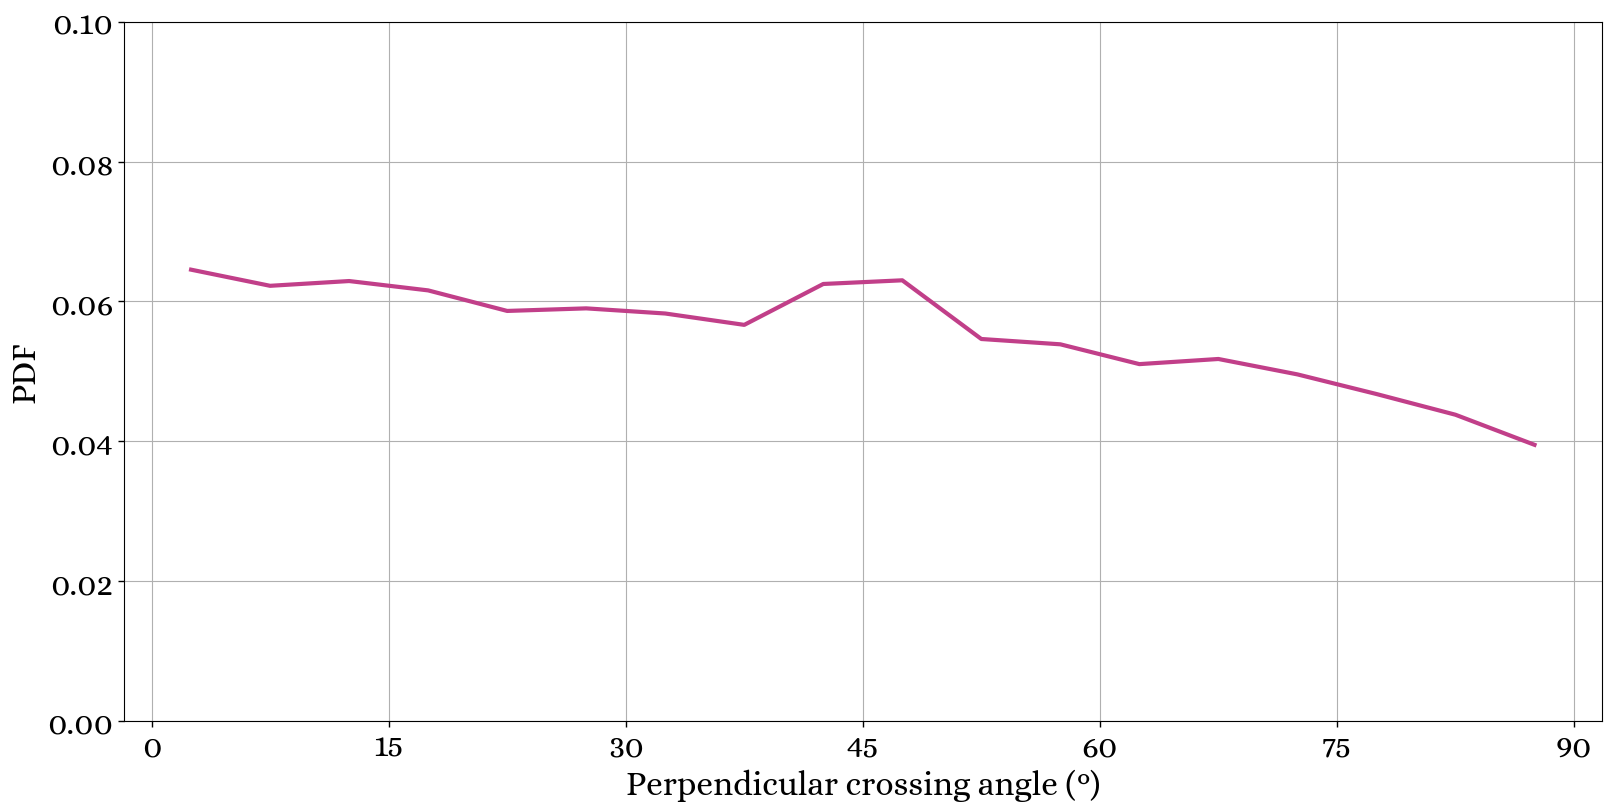

In [159]:
fig,ax = reg_fig()

h = np.histogram(np.abs(np.abs(adcp['current_angle'])-90),bins=np.arange(0,91,5))

ax.plot(np.arange(2.5,91,5).round(1),h[0]/h[0].sum(),c=c20,lw=3)
ax.set(xticks=np.arange(0,91,15),ylim=(0,0.1),ylabel="PDF",xlabel="Perpendicular crossing angle (°)")
#ax.xaxis.set_major_formatter(FuncFormatter(pc_formatter))
ax.grid()

In [160]:
adcp['current_angle']

<xarray.DataArray 'current_angle' (time: 38105)>
array([  39.93413703,   48.10772802,   54.96345878, ...,  -42.16034906,
       -140.67560576, -137.23263108])
Coordinates:
    trajectory  float32 1.02e+03
  * time        (time) datetime64[ns] 2019-01-19T04:00:00 ... 2019-08-03T04:2...
    latitude    (time) float64 ...
    longitude   (time) float64 ...

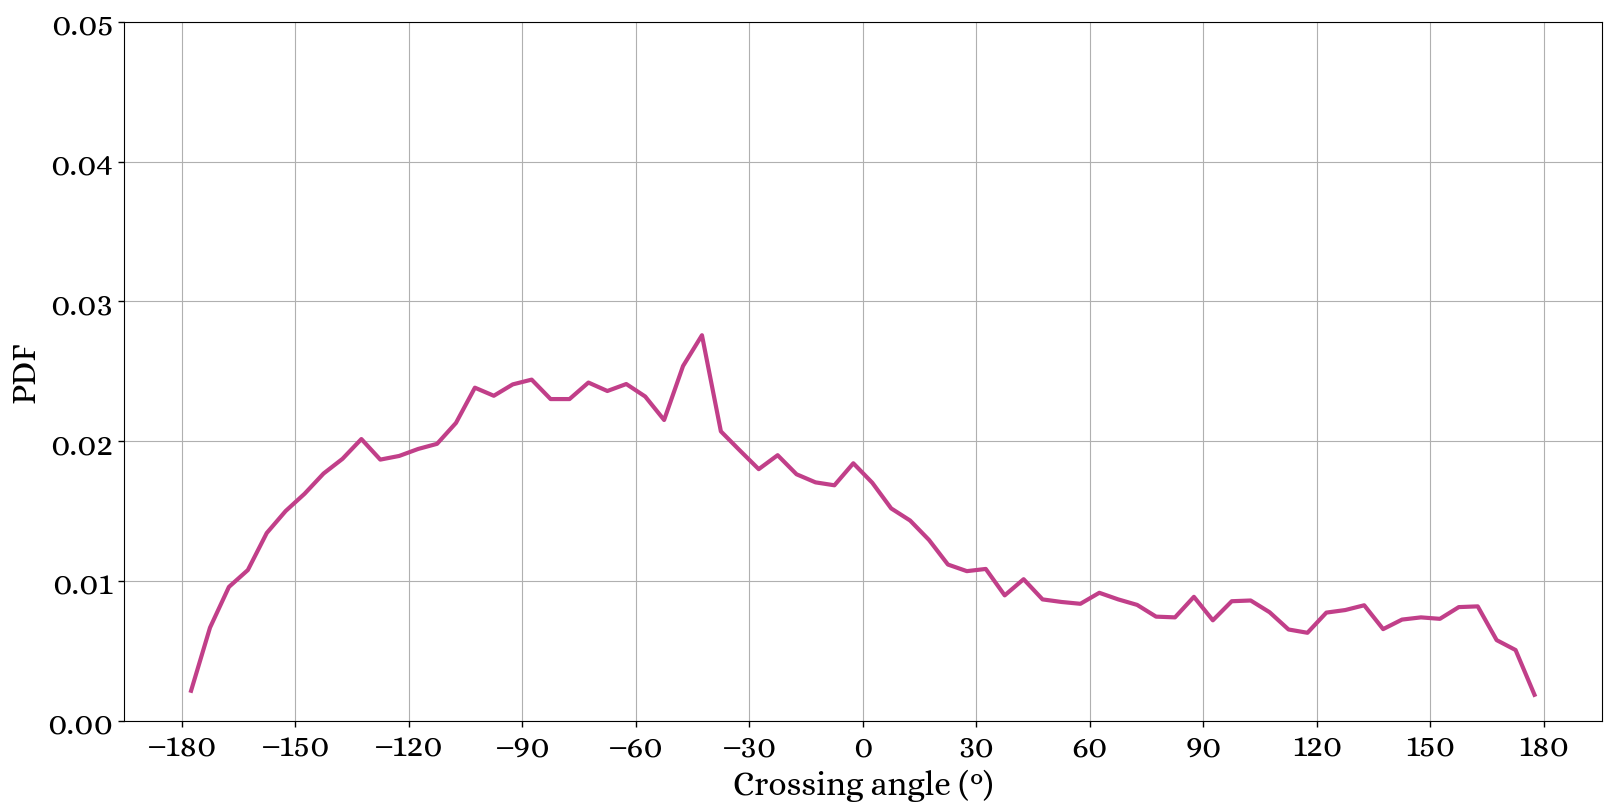

In [164]:
fig,ax = reg_fig()

h = np.histogram(adcp['current_angle'],bins=np.arange(-180,181,5))

ax.plot(np.arange(-177.5,181,5).round(1),h[0]/h[0].sum(),c=c20,lw=3)
ax.set(xticks=np.arange(-180,181,30),ylim=(0,0.05),ylabel="PDF",xlabel="Crossing angle (°)")
#ax.xaxis.set_major_formatter(FuncFormatter(pc_formatter))
ax.grid()

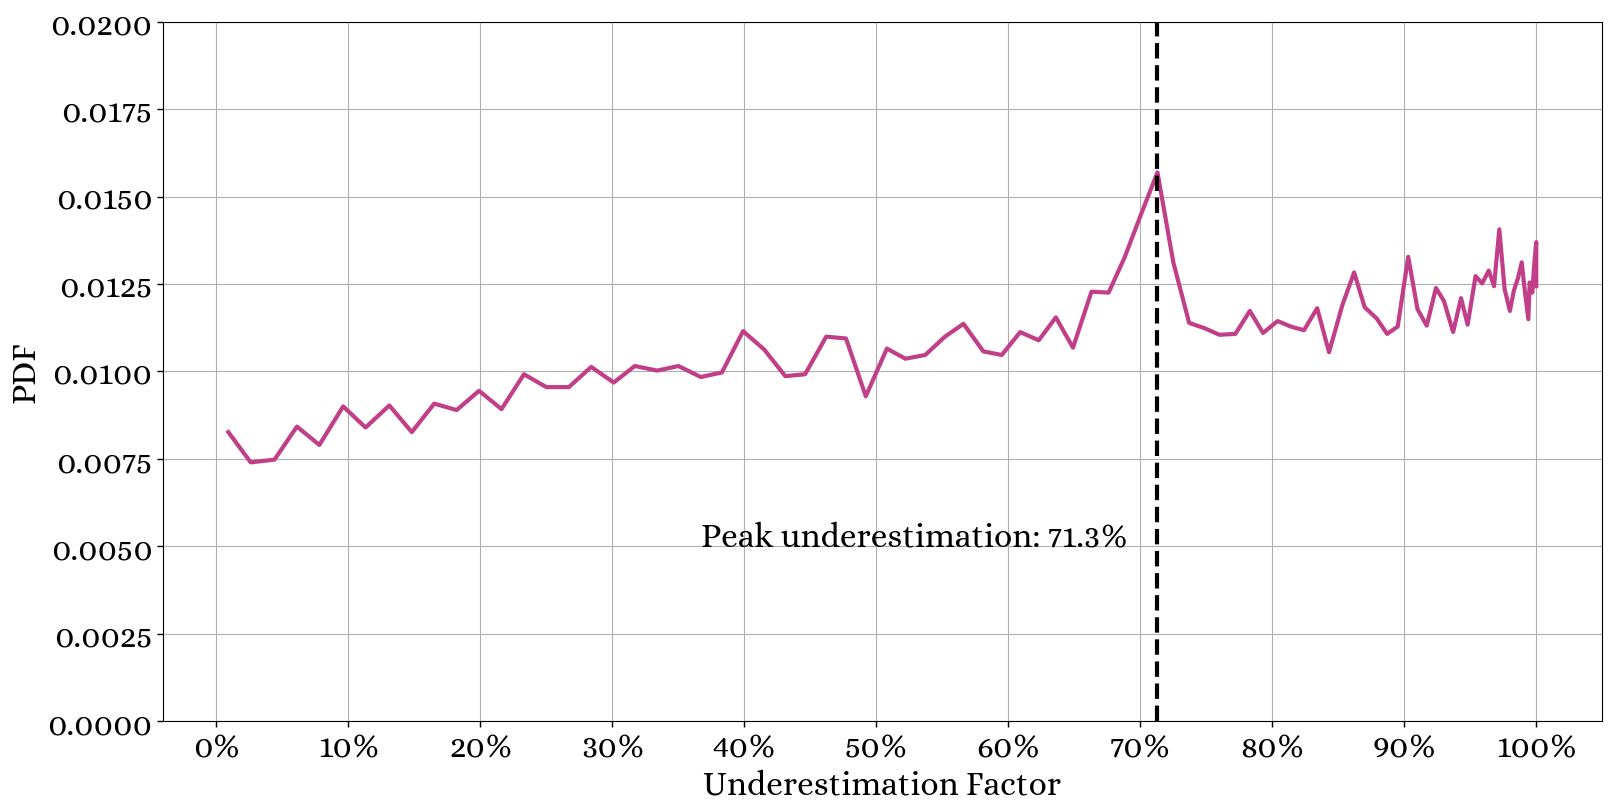

In [23]:
fig, ax = reg_fig()

# Calculate histogram of the deviation angles
h = np.histogram(np.abs(np.abs(adcp['current_angle']) - 90), bins=np.arange(0, 91, 1))

# Plot the histogram with x-axis representing the percentage of alignment with perpendicularity
ax.plot((np.cos(np.deg2rad(np.arange(0.5, 90, 1))) * 100).round(1), h[0] / h[0].sum(), c=c20, lw=3)

# Add vertical line at the mean alignment
# ax.axvline(np.median(np.cos(np.deg2rad(np.abs(np.abs(adcp['current_angle']) - 90)))) * 100,lw=3,c="k",ls='--')
ax.axvline((np.cos(np.deg2rad(np.arange(0.5, 90, 1))) * 100).round(1)[np.argmax(h[0])],lw=3,c="k",ls='--')
underestimation_percentage=(np.cos(np.deg2rad(np.arange(0.5, 90, 1))) * 100).round(1)[np.argmax(h[0])]
# Set axis labels and formatting
ax.set(xticks=np.arange(0, 101, 10), ylabel="PDF", xlabel="Density gradient underestimation")
ax.xaxis.set_major_formatter(FuncFormatter(pc_formatter))
# Annotate the plot with information about the underestimation percentage
ax.text(69, 0.005, f"Peak underestimation: {underestimation_percentage:.1f}%", ha='right')

# Set axis labels and formatting
ax.set(xlabel="Underestimation Factor", ylabel="PDF", ylim=(0,0.02))
ax.grid()

In [189]:
# Calculate the underestimation factor using the actual distribution of crossing angles
underestimation_factor = np.median(np.cos(np.deg2rad(np.abs(np.abs(adcp['current_angle'])-90))))

# Convert the underestimation factor to percentage
underestimation_percentage = underestimation_factor * 100

In [190]:
underestimation_percentage

74.93686768922849

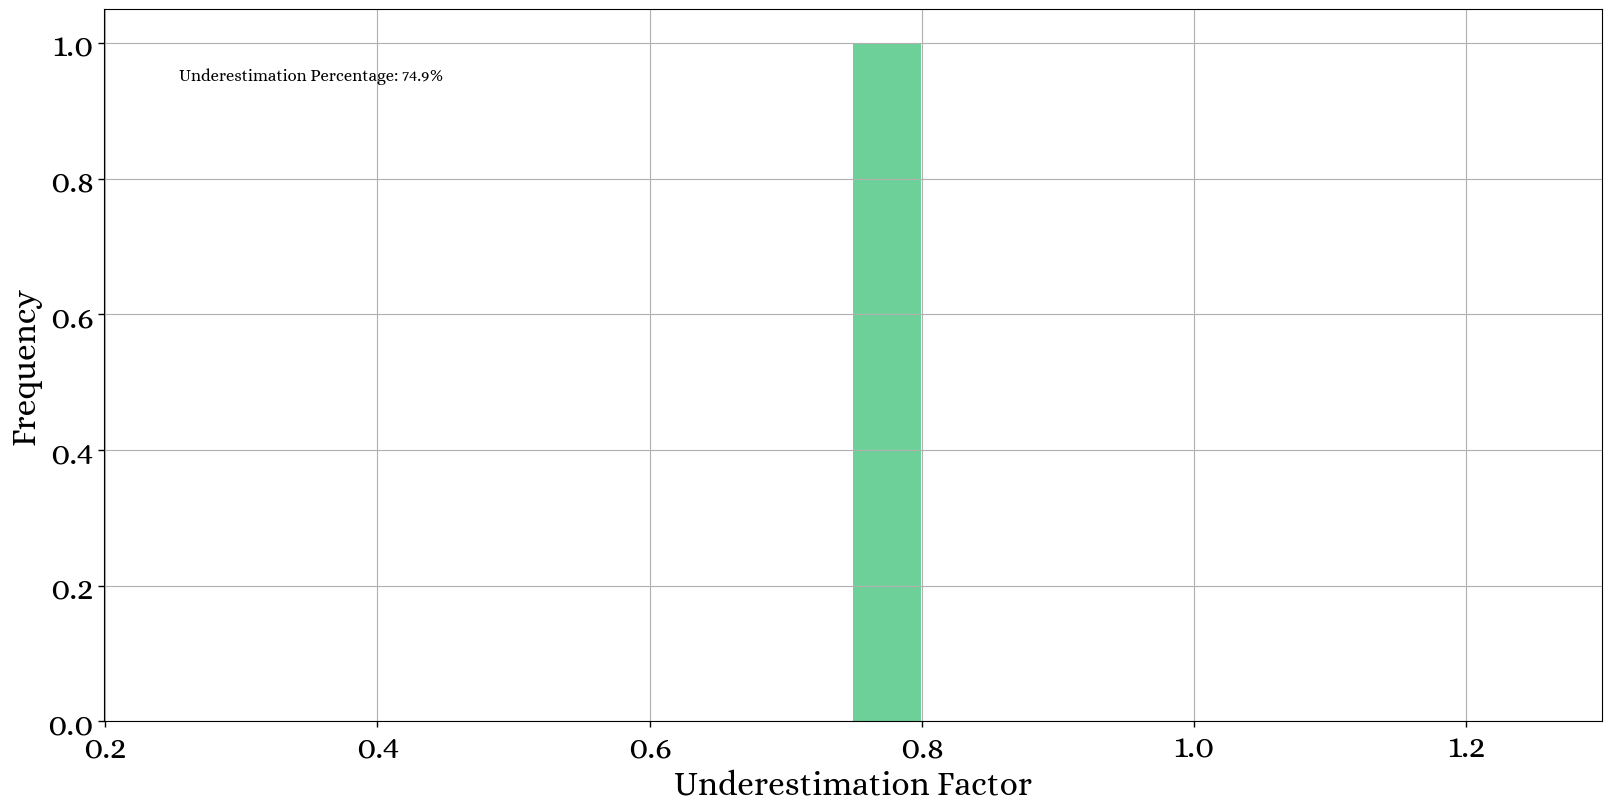

In [199]:
fig, ax = reg_fig()

# Calculate the underestimation factor using the actual distribution of crossing angles
underestimation_factor = np.median(np.cos(np.deg2rad(np.abs(np.abs(adcp['current_angle']) - 90))))

# Convert the underestimation factor to percentage
underestimation_percentage = underestimation_factor * 100

# Plot the distribution of the underestimation factor
ax.hist(underestimation_factor, bins=20, color=c22, alpha=0.75)

# Annotate the plot with information about the underestimation percentage
ax.text(0.05, 0.9, f"Underestimation Percentage: {underestimation_percentage:.1f}%", transform=ax.transAxes, fontsize=12)

# Set axis labels and formatting
ax.set(xlabel="Underestimation Factor", ylabel="Frequency")
ax.grid()


In [205]:
2000*11

22000

In [206]:
2000*10.2

20400.0

In [207]:
3000*0.03

90.0

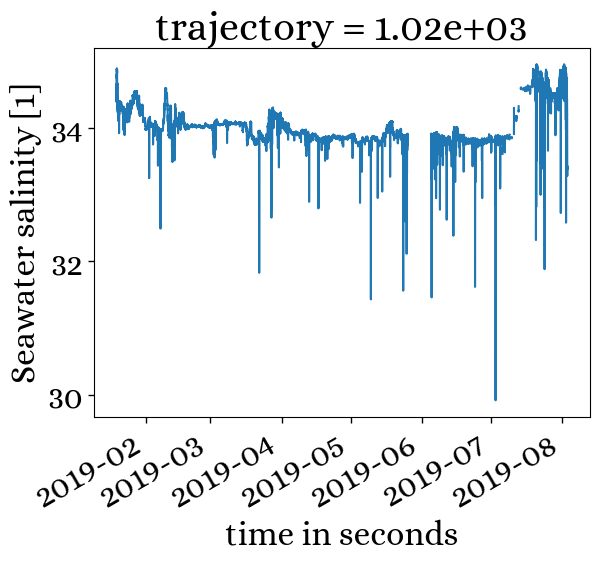

In [48]:
ds20["SAL_RBR_MEAN"].plot()

In [49]:
ds = np.diff(ds20["SAL_RBR_MEAN"])

In [50]:
ds

array([ 0.02 , -0.008, -0.004, ...,  0.001, -0.039,  0.043])

In [51]:
lim = np.nanpercentile(ds,95)

In [52]:
lim

0.006000000000000227

In [7]:
bad = np.abs(ds) > lim

In [17]:
idx = np.where(~((ds[:-1] < 0) & (ds[1:] > 0) & (bad[1:])))[0]+1

In [13]:
idx

array([     1,      2,      4, ..., 282266, 282267, 282268])

In [ ]:
idx

array([     1,      2,      4, ..., 282266, 282267, 282268])

In [ ]:
def qc_salinity(ds, variable, percentile, nsteps):
    
    idx = range(len(ds["time"]))
    
    for n in range(nsteps):
        dS = np.diff(ds[variable][idx])
        lim = np.nanpercentile(dS,percentile)
        bad = np.abs(dS) > lim
        idx = np.where(~((dS[:-1] < 0) & (dS[1:] > 0) & (bad[1:])))[0]+1
    
    return ds[variable][idx].interpolate_na("time")

In [63]:
def qc_salinity(ds, variable, percentile, nsteps):
    
    idx = range(len(ds["time"]))
    
    for n in range(nsteps):
        dS = np.diff(ds[variable][idx])
        lim = np.nanpercentile(dS,percentile)
        bad = np.abs(dS) > lim
        idx = np.where(~((dS[:-1] < 0) & (dS[1:] > 0) & (bad[1:])))[0]+1
    
    return ds[variable][idx].interpolate_na("time")

In [97]:
def detect_spikes_with_lag(dS, lag):
    """
    Detect spikes with lag based on the time difference of salinity.

    Parameters:
        dS (ndarray): Time difference of salinity.
        lag (int): Lag window size.

    Returns:
        ndarray: Boolean array indicating spike locations.
    """
    spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
    for i in range(len(dS)):
        if dS[i] < -threshold:  # Check for negative spike
            start_idx = max(0, i - lag)+1
            end_idx = min(len(dS), i + lag + 1)
            for j in range(i + 1, end_idx):  # Look ahead for positive spike within lag window
                if dS[j] > threshold:  # Check for positive spike
                    spikes[start_idx:j] = True  # Mark the spike region for removal
                    break
    return spikes[:-1]  # Remove the last element to match the length of dS

# Example usage
salinity = np.array([35, 35, 33, 33, 33, 35, 35, 35], dtype=float)  # Example salinity data
dS = np.diff(salinity)  # Compute time difference of salinity
threshold = 1#np.percentile(dS, 95)  # Calculate the 95th percentile of dS
lag = 5  # Lag window size

spikes_with_lag = detect_spikes_with_lag(dS, lag)
print("Spike indices with lag:", np.where(spikes_with_lag)[0])

# Output cleaned salinity array
cleaned_salinity = salinity.copy()
cleaned_salinity[np.concatenate(([False], spikes_with_lag))] = np.nan  # Adjust for the difference in dimensions
print("Cleaned salinity:", cleaned_salinity)


Spike indices with lag: [1 2 3]
Cleaned salinity: [35. 35. nan nan nan 35. 35. 35.]


In [201]:
def detect_spikes_with_lag(data, lag, percentile):
    """
    Detect spikes with lag based on the time difference of salinity.

    Parameters:
        data (ndarray): 1D array of the time series data.
        lag (int): Lag window size.

    Returns:
        ndarray: Boolean array indicating spike locations.
        ndarray: Cleaned time series data with spikes removed.
    """
    # Calculate time differences (dS)
    dS = np.diff(data)

    # Calculate the threshold based on a percentile of dS
    threshold = np.nanpercentile(np.abs(dS), percentile)
    
    spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
    for i in range(len(dS)):
        if (dS[i] <= -threshold) and (True in (dS[i:i+lag] >= threshold)):
            # Check if time difference is less than negative threshold and that there is an upspike within the allowed interval
            start_idx = i  # Start from the maximum possible index within the lag window
            end_idx = i + np.where((dS[i:i+lag] >= threshold) == True)[0][0]  # End at the current index
            spikes[start_idx+1:end_idx+1] = True  # Mark the spike region for removal

    cleaned_data = data.copy()
    cleaned_data[spikes] = np.nan  # Adjust for the difference in dimensions

    return cleaned_data

In [315]:
def detect_spikes_with_lag(data, lag, percentile):
    """
    Detect spikes with lag based on the time difference of salinity.

    Parameters:
        data (ndarray): 1D array of the time series data.
        lag (int): Lag window size.
        percentile (float): Percentile for calculating the threshold.

    Returns:
        ndarray: Boolean array indicating spike locations.
        ndarray: Cleaned time series data with spikes removed.
    """
    # Calculate time differences (dS)
    dS = np.diff(data)

    # Calculate the threshold based on a percentile of dS
    threshold = np.nanpercentile(np.abs(dS), 95)

    spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
    i = 0
    while i < len(dS):
        if (dS[i] <= -threshold) & (len(np.where(dS[i:i+lag] >= threshold)[0]) > 0):
            # Check if time difference is less than negative threshold
            start_idx = i  # Start from the maximum possible index within the lag window

            # Find the maximum positive change within the lag window
            max_positive_change_idx = i + np.argmax(np.where(dS[i:i+lag] >= threshold)[0])
            end_idx = max_positive_change_idx + 1  # End at the maximum positive change index

            spikes[start_idx+1:end_idx+1] = True  # Mark the spike region for removal
            i = max_positive_change_idx + 1  # Move to the next index after the spike region
        else:
            i += 1  # Move to the next index

    cleaned_data = data.copy()
    cleaned_data[spikes] = np.nan  # Adjust for the difference in dimensions

    return cleaned_data

In [ ]:
# Calculate time differences (dS)
dS = np.diff(data)

# Calculate the threshold based on a percentile of dS
threshold = np.nanpercentile(np.abs(dS), percentile)

spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
i = 0
while i < len(dS):
    if dS[i] <= -threshold:
        # Check if time difference is less than negative threshold
        start_idx = i  # Start from the maximum possible index within the lag window

        # Find the maximum positive change within the lag window
        max_positive_change_idx = i + np.argmax(dS[i:i+lag] >= threshold)
        end_idx = max_positive_change_idx + 1  # End at the maximum positive change index

        spikes[start_idx+1:end_idx+1] = True  # Mark the spike region for removal
        i = max_positive_change_idx + 1  # Move to the next index after the spike region
    else:
        i += 1  # Move to the next index

cleaned_data = data.copy()
cleaned_data[spikes] = np.nan  # Adjust for the difference in dimensions



In [316]:
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 5, 95)

<xarray.DataArray 'SAL_RBR_MEAN' (time: 282271)>
array([34.656, 34.676, 34.668, ..., 33.424,    nan, 33.428])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-01-19T04:00:00 ... 2019-08-03T04:3...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [ ]:
np.percentile(np.abs(np.diff(salinity)), 50)

2.0

In [ ]:
# Calculate time differences (dS)
dS = np.diff(ds20["SAL_RBR_MEAN"])

# Calculate the threshold based on a percentile of dS
threshold = np.nanpercentile(np.abs(dS), 95)
lag = 10


spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
for i in range(len(dS)):
    if (dS[i] <= -threshold) and (True in (dS[i:i+lag] >= threshold)):
        # Check if time difference is less than negative threshold and that there is an upspike within the allowed interval
        start_idx = i  # Start from the maximum possible index within the lag window
        end_idx = i + np.where((dS[i:i+lag] >= threshold) == True)[0][0]  # End at the current index
        spikes[start_idx+1:end_idx+1] = True  # Mark the spike region for removal
        
cleaned_data = ds20["SAL_RBR_MEAN"].copy()
cleaned_data[spikes] = np.nan  # Adjust for the difference in dimensions


In [ ]:
ds20["SAL_RBR_MEAN"].sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).diff("time")

<xarray.DataArray 'SAL_RBR_MEAN' (time: 50)>
array([ 1.000e-03,  1.000e-03,  1.000e-03,  0.000e+00, -1.000e-03,
        0.000e+00, -1.000e-03,  1.000e-03,  0.000e+00, -1.000e-03,
       -2.105e+00,  3.500e-02,  1.490e-01, -8.000e-03,  3.800e-02,
       -6.000e-03,  2.200e-02,  6.300e-02, -2.400e-02,  2.200e-02,
        1.300e-02,  5.100e-02,  1.390e-01,  3.600e-02,  1.060e-01,
       -1.500e-02,  2.200e-02, -1.000e-02,  3.100e-02,  3.100e-02,
        1.300e-02,  6.800e-02, -4.600e-02,  2.300e-02,  4.000e-02,
       -2.200e-02,  4.700e-02,  3.600e-02,  7.300e-02,  1.700e-01,
        1.470e-01,  1.660e-01,  6.910e-01,  0.000e+00,  1.000e-03,
        1.000e-03,  0.000e+00,  1.000e-03,  0.000e+00,  2.000e-03])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-03-22T05:51:00 ... 2019-03-22T06:4...
    trajectory  float32 1.02e+03

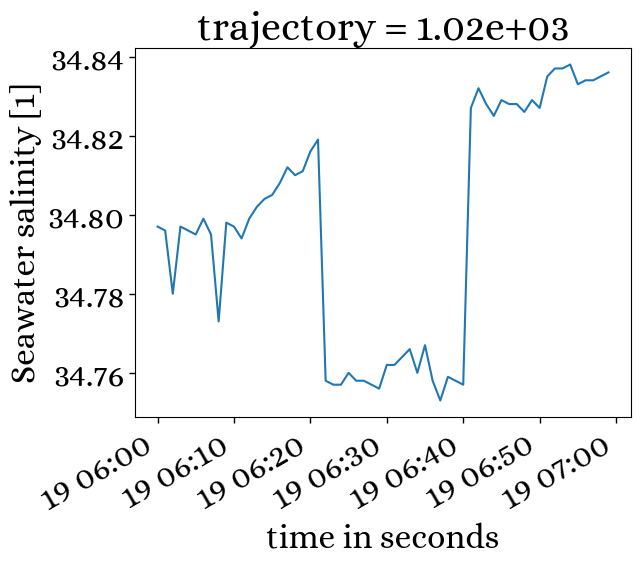

In [357]:
data[120:120+60].plot()

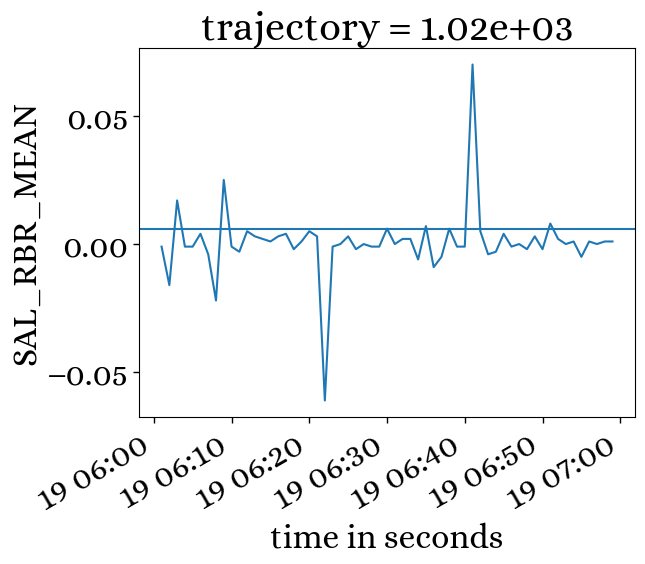

In [362]:
data[120:120+60].diff("time").plot()
plt.axhline(0.006)

In [375]:
np.where(np.diff(data)[120:120+60] > 0.006)[0][0]

2

In [376]:
np.where(np.diff(data)[120:120+60] < 0.006)[0][0]

0

In [385]:
data[100:100+60]

<xarray.DataArray 'SAL_RBR_MEAN' (time: 60)>
array([34.806, 34.807, 34.806, 34.807, 34.806, 34.809, 34.81 , 34.812, 34.813,
       34.811, 34.813, 34.814, 34.814, 34.811, 34.812, 34.806, 34.804, 34.799,
       34.798, 34.799, 34.797, 34.796, 34.78 , 34.797, 34.796, 34.795, 34.799,
       34.795, 34.773, 34.798, 34.797, 34.794, 34.799, 34.802, 34.804, 34.805,
       34.808, 34.812, 34.81 , 34.811, 34.816, 34.819, 34.758, 34.757, 34.757,
       34.76 , 34.758, 34.758, 34.757, 34.756, 34.762, 34.762, 34.764, 34.766,
       34.76 , 34.767, 34.758, 34.753, 34.759, 34.758])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-01-19T05:40:00 ... 2019-01-19T06:3...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

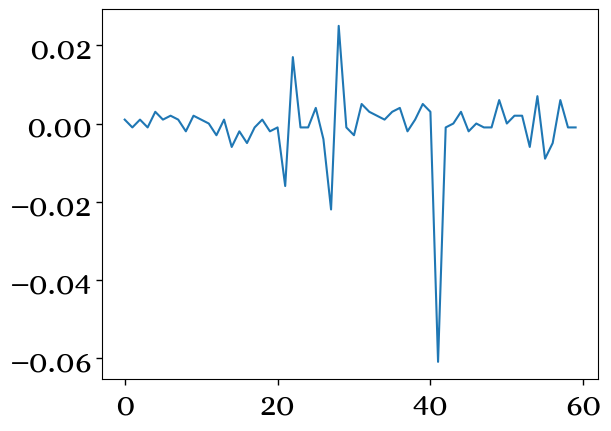

In [393]:
plt.plot(dS[100:100+60])

In [744]:
hanna = ds20[variable+"_MEAN"].where(ds20["SAL_RBR_STDDEV"]<0.01)[100:100+100]

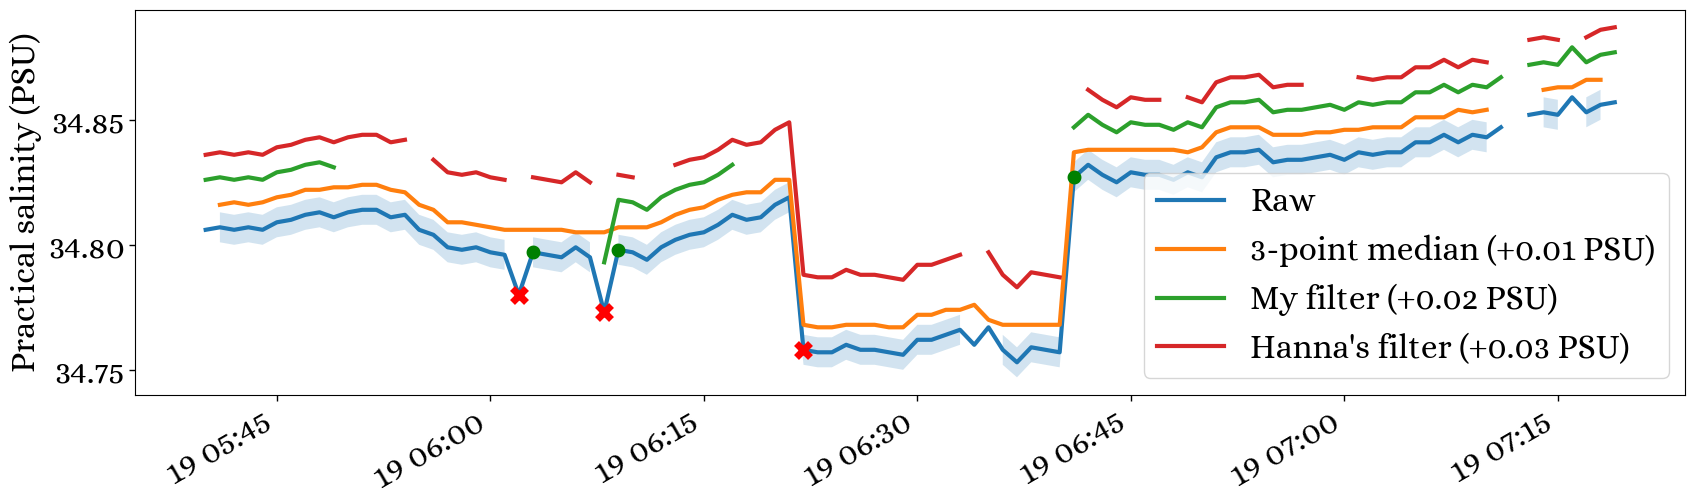

In [750]:
fig,ax = plt.subplots(figsize=(20,5))

data[100:100+100].plot(lw=3,label="Raw")
(data[100:100+100].rolling(time=3,center=True).median("time")+0.01).plot(lw=3,label="3-point median (+0.01 PSU)")
(cleaned_data+0.02).plot(lw=3,label="My filter (+0.02 PSU)")
#data[100:100+100].where(np.abs(data[100:100+100]-data[100:100+100].rolling(time=3,center=True).median("time")) < 0.006).plot(lw=3,label="Stina's filter")

ax.fill_between(data[100:100+100]["time"],
                data[100:100+100].where(np.abs(data[100:100+100]-data[100:100+100].rolling(time=3,center=True).median("time")) < 0.006)-0.006,
                data[100:100+100].where(np.abs(data[100:100+100]-data[100:100+100].rolling(time=3,center=True).median("time")) < 0.006)+0.006,
                fc="C0",alpha=0.2)


dS = np.diff(data)
downspike = (np.where(dS[100:100+100] < -0.01)[0]+1)
upspike = (np.where(dS[100:100+100] > 0.01)[0]+1)

# ax.axhline(data[100:100+100][41]-0.01)
# ax.axhline(data[100:100+100][41]+0.01)


plt.plot(data["time"][100:100+100][downspike],data[100:100+100][downspike],marker="x",c="r",ls="",mew=5,ms=10)
plt.plot(data["time"][100:100+100][upspike],data[100:100+100][upspike],marker=".",c="g",ls="",mew=5,ms=10)

ax.plot(hanna.time,hanna+0.03,lw=3,label="Hanna's filter (+0.03 PSU)",zorder=3,c='C3',ls='-')


ax.set(title="", xlabel="",ylabel="Practical salinity (PSU)")
ax.legend()

In [ ]:
dist = np.insert(np.cumsum(gsw.distance(data.longitude,data.latitude)),0,0)

In [ ]:
(data["time"]-data["time"][0]).values.astype("timedelta64[m]")

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='timedelta64[m]')

In [ ]:
data["minutes"] = ("time"),(data["time"]-data["time"][0]).values.astype("timedelta64[m]")

In [558]:
range_threshold = 30
data_threshold  = 0.01

data = ds20["SAL_RBR_MEAN"].copy()
dS = np.diff(data)

downspike = (np.where(dS <= -data_threshold)[0]+1)
upspike = (np.where(dS >= data_threshold)[0]+1)



# Create a mask array with False values
mask = np.zeros(len(data), dtype=bool)

# Set True for indices between matched pairs of downspike and upspike
for down_idx in downspike:
    for up_idx in upspike:
        if down_idx + 1 <= up_idx <= down_idx + range_threshold:
            mask[down_idx:up_idx] = True
            break  # Exit the inner loop if a corresponding index is found

# Set the masked elements to NaN in your data array
clean_data = data.copy()
clean_data[mask] = np.nan


data["minutes"] = ("time"),((data["time"]-data["time"][0]).values.astype("timedelta64[m]")).astype(int)
clean_data["minutes"] = ("time"),((data["time"]-data["time"][0]).values.astype("timedelta64[m]")).astype(int)

AttributeError: 'list' object has no attribute 'plot'

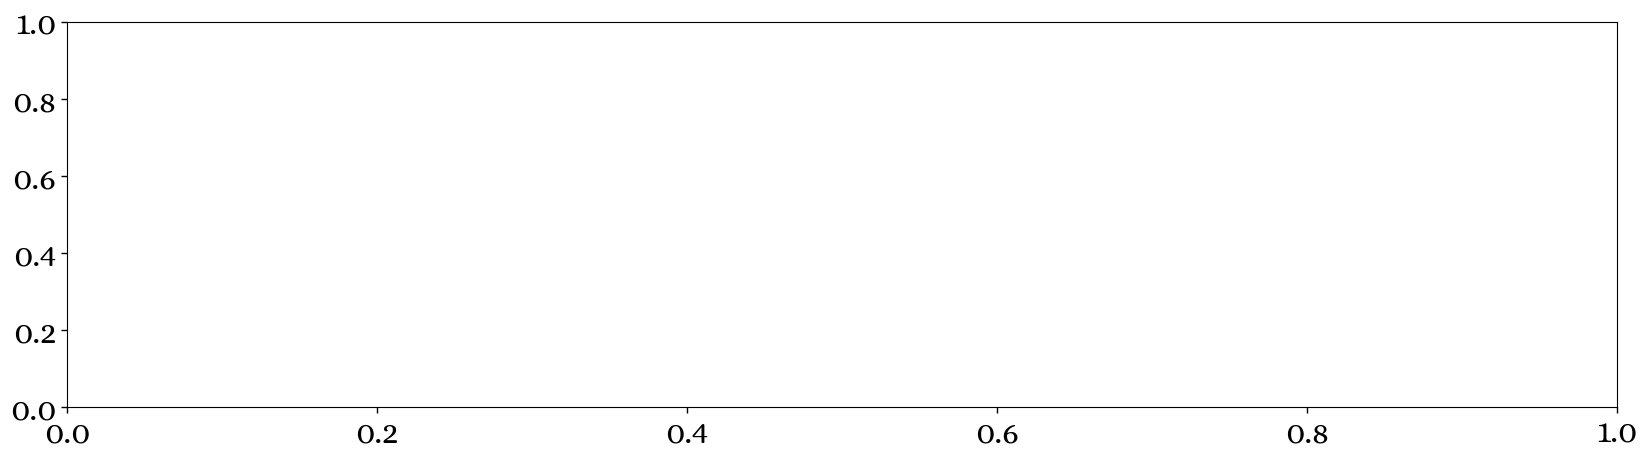

In [125]:
fig,ax = plt.subplots(figsize=(20,5))

data.plot(x="minutes",lw=3,label="Raw")
data.rolling(time=3,center=True).median("time").plot(x="minutes",lw=3,label="3-point median")
clean_data.plot(x="minutes",lw=3,label="My filter")

bx=ax.twiny()
bx.set(xlabel="Distance (km)",xlim=(0,np.nanmax(dist/1000)))
bx.set_xticks(np.linspace(0,np.nanmax(dist/1000),6).round(1))

ax.set_xlim(0,100)

ax.set(title="", xlabel="Time (min)",ylabel="Practical salinity (PSU)")
ax.legend()
ax.grid()

In [650]:
ds20

<xarray.Dataset>
Dimensions:                         (time: 282271)
Coordinates:
    latitude                        (time) float64 ...
    longitude                       (time) float64 ...
  * time                            (time) datetime64[ns] 2019-01-19T04:00:00...
    trajectory                      float32 1.02e+03
Data variables: (12/50)
    SOG                             (time) float64 ...
    COG                             (time) float64 ...
    HDG                             (time) float64 ...
    HDG_WING                        (time) float64 ...
    WING_ANGLE                      (time) float64 ...
    UWND_MEAN                       (time) float64 ...
    ...                              ...
    O2_SAT_RBR_STDDEV               (time) float64 ...
    TEMP_O2_RBR_MEAN                (time) float64 ...
    TEMP_O2_RBR_STDDEV              (time) float64 ...
    CHLOR_RBR_MEAN                  (time) float64 ...
    CHLOR_RBR_STDDEV                (time) float64 ...
    Salinity_QC                     (time) float64 34.66 34.68 34.67 ... nan nan
Attributes: (12/38)
    title:                     Antarctica Circumnavigation Surface Data
    summary:                   This data set was collected from the first Sai...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east

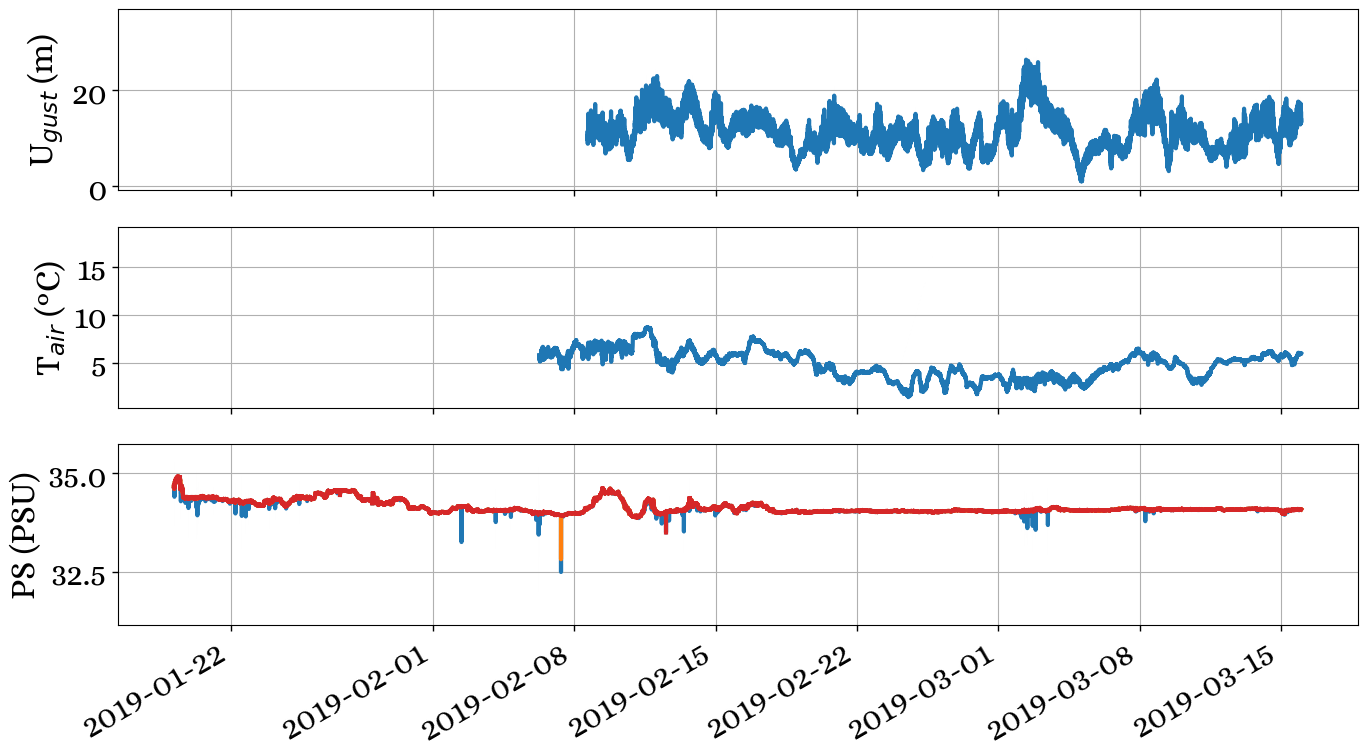

In [740]:
fig, ax = plt.subplots(3,1,figsize=(16,8),sharex=True)

interval = slice("2019-01-19","2019-03-15")

ds20["SAL_RBR_MEAN"].sel(time=interval).rolling(time=3,center=True).median("time").plot(lw=3,label="3-point median",ax=ax[2],zorder=3,c='C1')

for axs,variable,l in zip(ax,["GUST_WND","TEMP_AIR","SAL_RBR"],["U$_{gust}$ (m)", "T$_{air}$ (°C)","PS (PSU)"]):
    
    ds20[variable + "_MEAN"].sel(time=interval).plot(lw=3,label="Raw",ax=axs,c="C0",zorder=2)
    
    axs.fill_between(ds20["time"].sel(time=interval).values,
                    ds20[variable + "_MEAN"].sel(time=interval)+ds20[variable + "_STDDEV"].sel(time=interval),
                    ds20[variable + "_MEAN"].sel(time=interval)-ds20[variable + "_STDDEV"].sel(time=interval),
                    fc='C0',alpha=0.25)

    if "SAL" in variable:
        ds20[variable+"_MEAN"].sel(time=interval).rolling(time=5,center=True).median("time").plot(lw=3,label="5-point median",ax=axs,zorder=3,c='C1')
        ds20[variable+"_MEAN"].sel(time=interval).where(ds20["SAL_RBR_STDDEV"]<0.01).plot(lw=3,label="Hanna's filter",ax=axs,zorder=3,c='C3',ls='-')

    
    axs.set(title="", xlabel="",ylabel=l)
    axs.grid()    

#axs.legend()

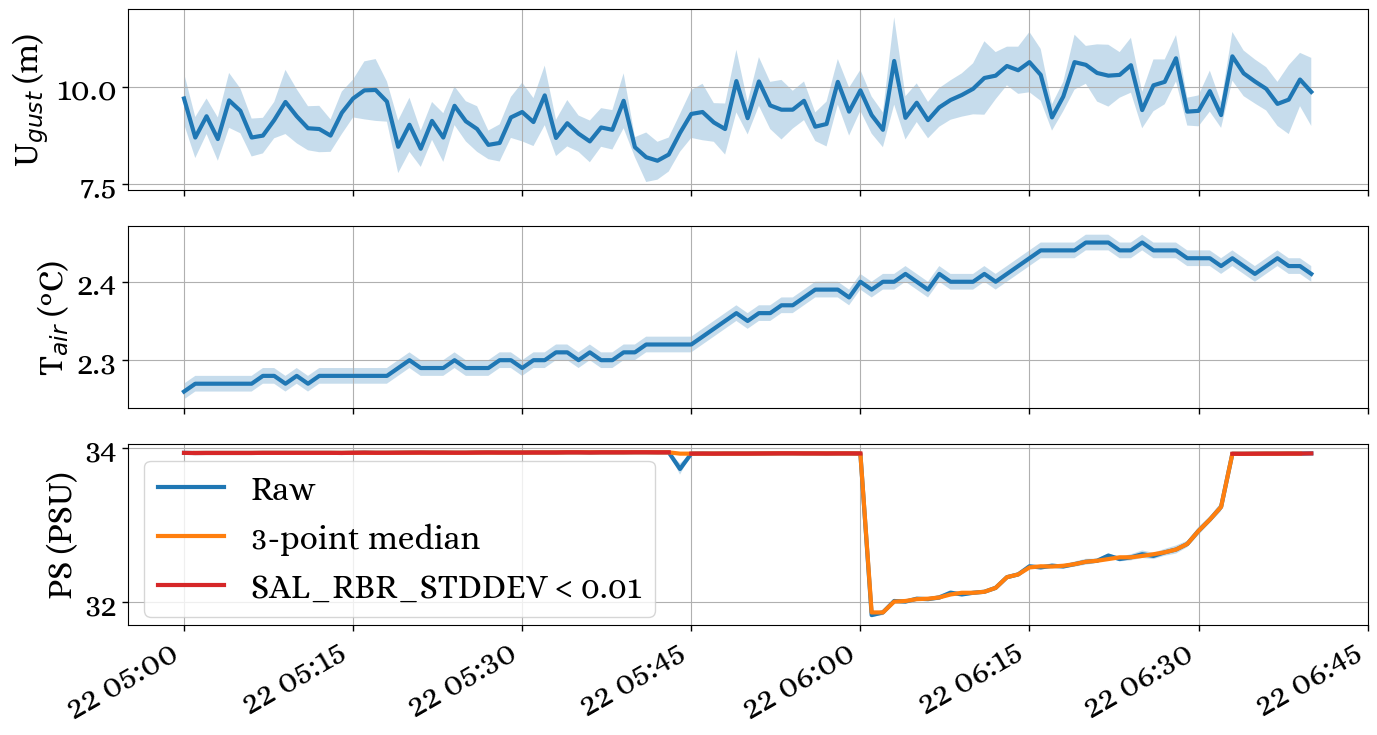

In [9]:
fig, ax = plt.subplots(3,1,figsize=(16,8),sharex=True)

interval = slice("2019-03-22 05:00","2019-03-22 06:40")

for i,(axs,variable,l) in enumerate(zip(ax,["GUST_WND","TEMP_AIR","SAL_RBR"],["U$_{gust}$ (m)", "T$_{air}$ (°C)","PS (PSU)"])):
    
    ds20[variable + "_MEAN"].sel(time=interval).plot(lw=3,label="Raw",ax=axs,c="C0",zorder=2)
    
    axs.fill_between(ds20["time"].sel(time=interval).values,
                    ds20[variable + "_MEAN"].sel(time=interval)+ds20[variable + "_STDDEV"].sel(time=interval),
                    ds20[variable + "_MEAN"].sel(time=interval)-ds20[variable + "_STDDEV"].sel(time=interval),
                    fc='C0',alpha=0.25)

    if "SAL" in variable:
        ds20[variable+"_MEAN"].sel(time=interval).rolling(time=3,center=True).median("time").plot(lw=3,label="3-point median",ax=axs,zorder=3,c='C1')
        ds20[variable+"_MEAN"].sel(time=interval).where(ds20["SAL_RBR_STDDEV"]<0.01).plot(lw=3,label="SAL_RBR_STDDEV < 0.01",ax=axs,zorder=3,c='C3',ls='-')

    
    axs.set(title="", xlabel="",ylabel=l)
    axs.grid()    

axs.legend()



In [50]:
ds20["SALINITY_QC_MEAN"] = ds20["SAL_RBR_MEAN"].where(ds20["SAL_RBR_STDDEV"]<np.nanpercentile(ds20['SAL_RBR_STDDEV'].values,95).round(3)).interpolate_na("time")
ds20["SALINITY_QC_STDDEV"] = ds20["SAL_RBR_STDDEV"].where(ds20["SAL_RBR_STDDEV"]<np.nanpercentile(ds20['SAL_RBR_STDDEV'].values,95).round(3)).interpolate_na("time")

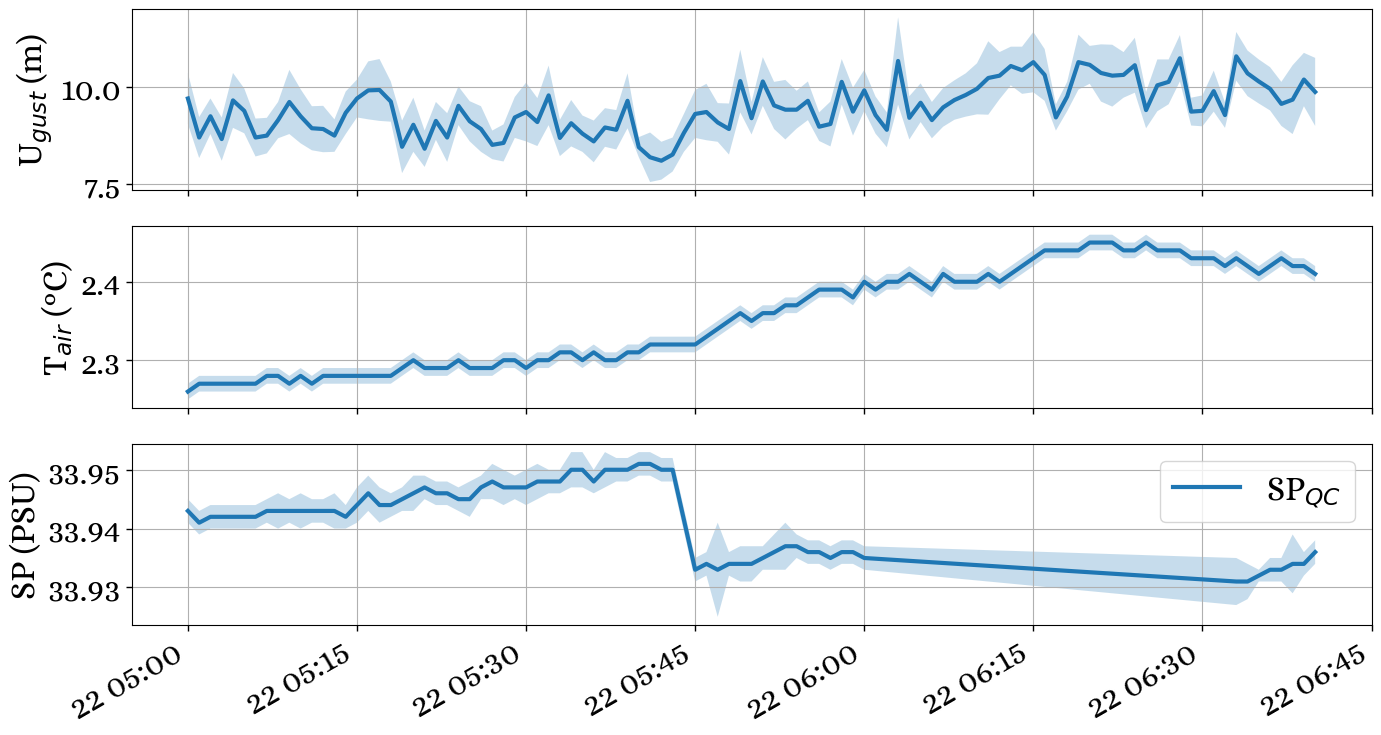

In [15]:
fig, ax = plt.subplots(3,1,figsize=(16,8),sharex=True)

interval = slice("2019-03-22 05:00","2019-03-22 06:40")

for i,(axs,variable,l) in enumerate(zip(ax,["GUST_WND","TEMP_AIR","SALINITY_QC"],["U$_{gust}$ (m)", "T$_{air}$ (°C)","SP (PSU)"])):
    
    ds20[variable + "_MEAN"].sel(time=interval).plot(lw=3,label="SP$_{QC}$" if "SAL" in variable else "Raw",ax=axs,c="C0",zorder=2)
    
    axs.fill_between(ds20["time"].sel(time=interval).values,
                    ds20[variable + "_MEAN"].sel(time=interval)+ds20[variable + "_STDDEV"].sel(time=interval),
                    ds20[variable + "_MEAN"].sel(time=interval)-ds20[variable + "_STDDEV"].sel(time=interval),
                    fc='C0',alpha=0.25)
    
    axs.set(title="", xlabel="",ylabel=l)
    axs.grid()    

axs.legend()



In [ ]:
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(16,8),sharey=True)


h1=ax.hist(np.diff(ds20["SAL_RBR_MEAN"]),bins=np.arange(-2,2.01,0.01),zorder=2, histtype="stepfilled", lw=2, ec="C0",label="Raw")
h2=ax.hist(np.diff(ds20["SALINITY_QC_MEAN"]),bins=np.arange(-2,2.01,0.01),zorder=2, histtype="stepfilled", lw=2, ec="C1",label="STD < 0.01")

h3=ax.hist(ds20["SAL_RBR_STDDEV"],bins=np.arange(0,2,0.01),zorder=2, histtype="stepfilled", lw=2, ec="C1",label="STD < 0.01")

ax.set_yscale("log")
ax.grid(zorder=1)
ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()


In [115]:
matplotlib.patches.FancyBboxPatch?

Object `matplotlib.patches.FancyBboxPatch` not found.


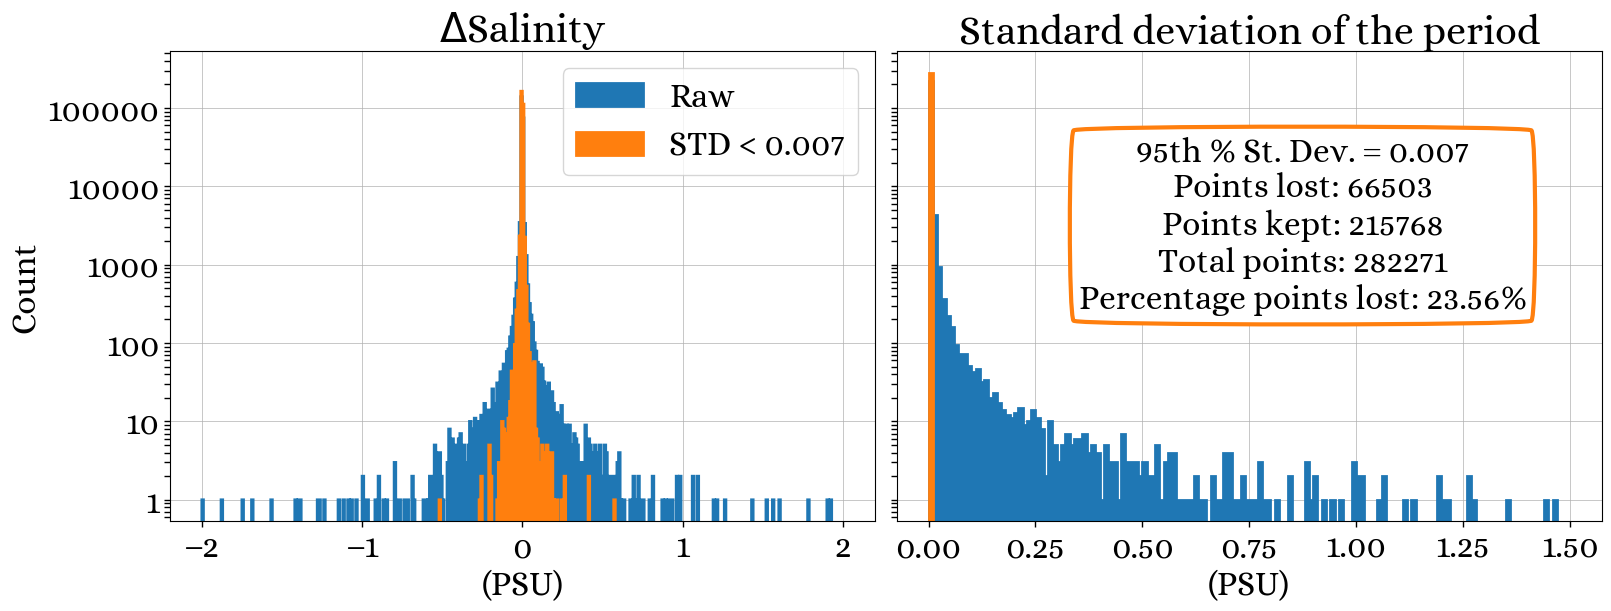

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create subplots with constrained layout and shared y-axis
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 6), sharey=True)

# Data and labels for plotting
data = [(np.diff(ds20["SAL_RBR_MEAN"]), np.diff(ds20["SALINITY_QC_MEAN"])),
        (ds20["SAL_RBR_STDDEV"], ds20["SALINITY_QC_STDDEV"])]
colors = ['C0', 'C1']
labels = [['Raw', f'STD < {np.nanpercentile(ds20["SAL_RBR_STDDEV"].values, 95):.3f}'], ['Raw St.Dev', 'QC St.Dev']]
bins = [np.arange(-2, 2.01, 0.01), np.arange(0, 1.51, 0.01)]
titles = [r'$\Delta$Salinity', 'Standard deviation of the period']
xlabels = ['(PSU)', '(PSU)']
ylabels = ['Count', '']

# Loop through subplots and data, plotting histograms
for i, (axi, (d1, d2), color, label, b, title, xlabel, ylabel) in enumerate(zip(ax, data, colors, labels, bins, titles, xlabels, ylabels)):
    h1 = axi.hist(d1, bins=b, zorder=2, histtype="stepfilled", lw=2, ec="C0", label=label[0])
    h2 = axi.hist(d2, bins=b, zorder=2, histtype="stepfilled", lw=2, ec="C1", label=label[1])
    
    axi.set(title=title, xlabel=xlabel, ylabel=ylabel, yscale="log")
    axi.grid(True, linestyle='-', linewidth=0.5)

    # Add legend to the first subplot
    if i == 0:
        axi.legend()

# Calculate additional statistics
#lost_points = np.sum(np.isnan(ds20['SAL_RBR_STDDEV']))
kept_points = np.sum(ds20['SAL_RBR_STDDEV'] < np.nanpercentile(ds20["SAL_RBR_STDDEV"], 95).round(3)).values
total_points = len(ds20['SAL_RBR_STDDEV'])
lost_points = total_points - kept_points
percentage_lost = (lost_points / total_points) * 100

ax[1].text(0.875, np.sqrt(10) * 1e3,
           f"95th % St. Dev. = {np.nanpercentile(ds20['SAL_RBR_STDDEV'].values, 95):.3f}\n"
           f"Points lost: {lost_points}\n"
           f"Points kept: {kept_points}\n"
           f"Total points: {total_points}\n"
           f"Percentage points lost: {percentage_lost:.2f}%",
           ha="center", va="center", bbox=dict(facecolor='w', alpha=1, ec='C1', lw=3, boxstyle="round4"))



# Set y-scale to logarithmic for the first subplot and format y-axis ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter())

plt.show()

In [644]:
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

# Example salinity data
salinity = ds20["SAL_RBR_MEAN"].values.copy()

# Set the threshold for going below salinity
below_threshold = 0.01

# Set the maximum number of steps to search for the next rise above threshold
max_steps = 60

# Create a mask array with False values
mask = np.zeros(len(salinity), dtype=bool)

# Iterate over the salinity data
for i in tqdm(range(len(salinity)), "Cleaning salinity"):
    # Check if the difference from the current value to the previous one is above the threshold
    if i > 0 and salinity[i-1] - salinity[i] > below_threshold:
        # Initialize a counter for steps below the threshold
        steps_below_threshold = 1
        
        # Continue iterating to find the next rise above threshold
        j = 1
        while j <= max_steps and i+j < len(salinity):
            if salinity[i-1] - salinity[i+j] > below_threshold*2:
                steps_below_threshold += 1
            else:
                break  # Break the loop if the difference rises above the threshold
            j += 1
        
        # Mask the data if we're below the threshold for too many steps
        if steps_below_threshold >= max_steps or (i + j) == len(salinity):
            mask[i:i+j+1] = True
        else:
            mask[i] = True  # Mask even if there's only one instance of a spike

# Set the masked elements to NaN in the data array
salinity[mask] = np.nan
ds20["Salinity_QC"] = ("time"), salinity

print("Salinity data with masked values below the threshold:\n", salinity)


Cleaning salinity:   0%|          | 0/282271 [00:00<?, ?it/s]

Salinity data with masked values below the threshold:
 [34.656 34.676 34.668 ...    nan    nan    nan]


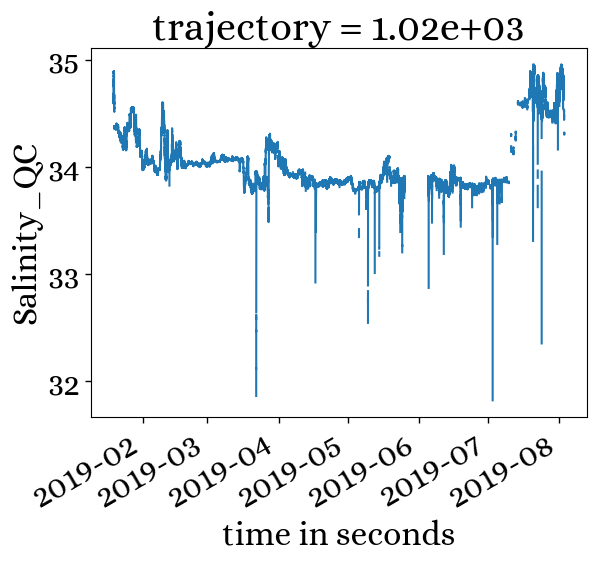

In [645]:
ds20["Salinity_QC"].plot()

In [563]:
data[downspike].sel(time=slice("2019-03-22 05:50","2019-03-22 06:40"))

<xarray.DataArray 'SAL_RBR_MEAN' (time: 5)>
array([31.83 , 32.099, 32.451, 32.56 , 32.601])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-03-22T06:01:00 ... 2019-03-22T06:2...
    trajectory  float32 1.02e+03
    minutes     (time) int64 89401 89409 89416 89423 89426
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [493]:
spike_periods = []
n=60
threshold = 0.006
for i in range(len(dS[100:100+100])):
    if dS[i] < -threshold:  # Check for negative spike
        next_spike_idx = None
        for j in range(i + 1, min(i + n + 1, len(dS[100:100+100]))):
            if (dS[100:100+100][j] > threshold and dS[100:100+100][i] < 0) or (dS[100:100+100][j] < -threshold and dS[100:100+100][i] > 0):
                next_spike_idx = j
                break

        if next_spike_idx is not None:
            spike_periods.append((i, next_spike_idx))

print("Spike periods:", spike_periods)

Spike periods: [(1, 22), (8, 22), (9, 14), (10, 14), (12, 22), (13, 14), (16, 22), (19, 22), (22, 27), (24, 28), (37, 49)]


In [498]:
dS[100:200] < -threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False])

In [496]:
dS[100:200]

array([ 0.001, -0.001,  0.001, -0.001,  0.003,  0.001,  0.002,  0.001,
       -0.002,  0.002,  0.001,  0.   , -0.003,  0.001, -0.006, -0.002,
       -0.005, -0.001,  0.001, -0.002, -0.001, -0.016,  0.017, -0.001,
       -0.001,  0.004, -0.004, -0.022,  0.025, -0.001, -0.003,  0.005,
        0.003,  0.002,  0.001,  0.003,  0.004, -0.002,  0.001,  0.005,
        0.003, -0.061, -0.001,  0.   ,  0.003, -0.002,  0.   , -0.001,
       -0.001,  0.006,  0.   ,  0.002,  0.002, -0.006,  0.007, -0.009,
       -0.005,  0.006, -0.001, -0.001,  0.07 ,  0.005, -0.004, -0.003,
        0.004, -0.001,  0.   , -0.002,  0.003, -0.002,  0.008,  0.002,
        0.   ,  0.001, -0.005,  0.001,  0.   ,  0.001,  0.001, -0.002,
        0.003, -0.001,  0.001,  0.   ,  0.004,  0.   ,  0.003, -0.003,
        0.003, -0.001,  0.004,    nan,    nan,  0.001, -0.001,  0.007,
       -0.006,  0.003,  0.001,  0.   ])

In [495]:
data[100:200].values

array([34.806, 34.807, 34.806, 34.807, 34.806, 34.809, 34.81 , 34.812,
       34.813, 34.811, 34.813, 34.814, 34.814, 34.811, 34.812, 34.806,
       34.804, 34.799, 34.798, 34.799, 34.797, 34.796, 34.78 , 34.797,
       34.796, 34.795, 34.799, 34.795, 34.773, 34.798, 34.797, 34.794,
       34.799, 34.802, 34.804, 34.805, 34.808, 34.812, 34.81 , 34.811,
       34.816, 34.819, 34.758, 34.757, 34.757, 34.76 , 34.758, 34.758,
       34.757, 34.756, 34.762, 34.762, 34.764, 34.766, 34.76 , 34.767,
       34.758, 34.753, 34.759, 34.758, 34.757, 34.827, 34.832, 34.828,
       34.825, 34.829, 34.828, 34.828, 34.826, 34.829, 34.827, 34.835,
       34.837, 34.837, 34.838, 34.833, 34.834, 34.834, 34.835, 34.836,
       34.834, 34.837, 34.836, 34.837, 34.837, 34.841, 34.841, 34.844,
       34.841, 34.844, 34.843, 34.847,    nan, 34.852, 34.853, 34.852,
       34.859, 34.853, 34.856, 34.857])

In [475]:
cleaned_data = data[100:100+100].copy()

for start_idx, end_idx in spike_periods:
    cleaned_data[start_idx+1:end_idx+1] = np.nan  # Mark the spike region for removal


In [476]:
cleaned_data

<xarray.DataArray 'SAL_RBR_MEAN' (time: 100)>
array([34.806, 34.807, 34.806, 34.807, 34.806, 34.809, 34.81 , 34.812, 34.813,
       34.811,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan, 34.773, 34.798, 34.797, 34.794, 34.799, 34.802, 34.804, 34.805,
       34.808, 34.812,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan, 34.827, 34.832,
       34.828, 34.825, 34.829, 34.828, 34.828, 34.826, 34.829, 34.827, 34.835,
       34.837, 34.837, 34.838, 34.833, 34.834, 34.834, 34.835, 34.836, 34.834,
       34.837, 34.836, 34.837, 34.837, 34.841, 34.841, 34.844, 34.841, 34.844,
       34.843, 34.847,    nan, 34.852, 34.853, 34.852, 34.859, 34.853, 34.856,
       34.857])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-01-19T05:40:00 ... 2019-01-19T07:1...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [ ]:
data

In [431]:
dS = np.diff(data)
downspike = (np.where(dS[100:100+100] < -0.006)[0]+1)
upspike = (np.where(dS[100:100+100] > 0.006)[0]+1)


In [454]:
data[100:100+100].where(np.abs(data[100:100+100]-data[100:100+100].rolling(time=5,center=True).median("time")) < 0.006)

<xarray.DataArray 'SAL_RBR_MEAN' (time: 100)>
array([   nan,    nan, 34.806, 34.807, 34.806, 34.809, 34.81 , 34.812,
       34.813, 34.811, 34.813, 34.814, 34.814, 34.811, 34.812, 34.806,
       34.804, 34.799, 34.798, 34.799, 34.797, 34.796,    nan, 34.797,
       34.796, 34.795, 34.799, 34.795,    nan, 34.798, 34.797, 34.794,
       34.799, 34.802, 34.804, 34.805, 34.808, 34.812, 34.81 , 34.811,
       34.816,    nan, 34.758, 34.757, 34.757, 34.76 , 34.758, 34.758,
       34.757, 34.756, 34.762, 34.762, 34.764, 34.766, 34.76 ,    nan,
       34.758, 34.753, 34.759, 34.758, 34.757, 34.827, 34.832, 34.828,
       34.825, 34.829, 34.828, 34.828, 34.826, 34.829, 34.827, 34.835,
       34.837, 34.837, 34.838, 34.833, 34.834, 34.834, 34.835, 34.836,
       34.834, 34.837, 34.836, 34.837, 34.837, 34.841, 34.841, 34.844,
       34.841, 34.844,    nan,    nan,    nan,    nan,    nan, 34.852,
          nan, 34.853,    nan,    nan])
Coordinates:
    latitude    (time) float64 -46.71 -46.71 -46.71 ... -46.76 -46.76 -46.76
    longitude   (time) float64 168.7 168.7 168.7 168.7 ... 168.9 168.9 168.9
  * time        (time) datetime64[ns] 2019-01-19T05:40:00 ... 2019-01-19T07:1...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [ ]:
max_positive_change_idx = i + np.argmax(np.where((dS[i:i+n] >= threshold) & (dS[i:i+n] <= -dS[i]))[0])

In [438]:
downspike

array([15, 22, 28, 42, 54, 56, 97])

In [433]:
upspike

array([23, 29, 50, 55, 58, 61, 71, 96])

In [436]:
dS[100:100+100]

array([ 0.001, -0.001,  0.001, -0.001,  0.003,  0.001,  0.002,  0.001,
       -0.002,  0.002,  0.001,  0.   , -0.003,  0.001, -0.006, -0.002,
       -0.005, -0.001,  0.001, -0.002, -0.001, -0.016,  0.017, -0.001,
       -0.001,  0.004, -0.004, -0.022,  0.025, -0.001, -0.003,  0.005,
        0.003,  0.002,  0.001,  0.003,  0.004, -0.002,  0.001,  0.005,
        0.003, -0.061, -0.001,  0.   ,  0.003, -0.002,  0.   , -0.001,
       -0.001,  0.006,  0.   ,  0.002,  0.002, -0.006,  0.007, -0.009,
       -0.005,  0.006, -0.001, -0.001,  0.07 ,  0.005, -0.004, -0.003,
        0.004, -0.001,  0.   , -0.002,  0.003, -0.002,  0.008,  0.002,
        0.   ,  0.001, -0.005,  0.001,  0.   ,  0.001,  0.001, -0.002,
        0.003, -0.001,  0.001,  0.   ,  0.004,  0.   ,  0.003, -0.003,
        0.003, -0.001,  0.004,    nan,    nan,  0.001, -0.001,  0.007,
       -0.006,  0.003,  0.001,  0.   ])

In [434]:
data[100:100+100][15]

<xarray.DataArray 'SAL_RBR_MEAN' ()>
array(34.806)
Coordinates:
    latitude    float64 ...
    longitude   float64 ...
    time        datetime64[ns] 2019-01-19T05:55:00
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

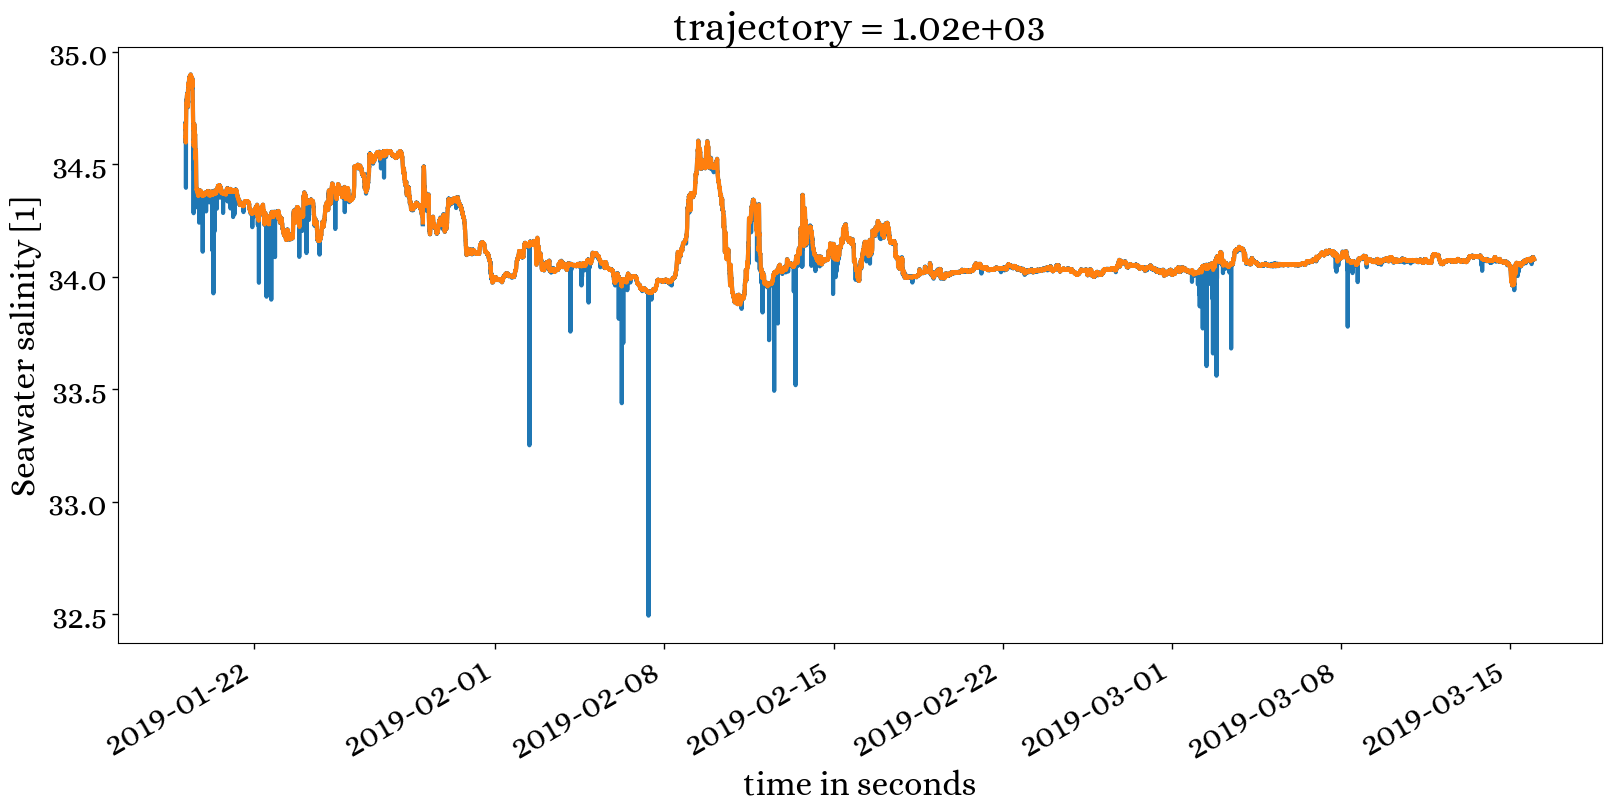

In [739]:
fig, ax = plt.subplots(1,1,figsize=(16,8),constrained_layout=True)

ds20["SAL_RBR_MEAN"].sel(time=interval).plot(ax=ax,lw=3,label="Raw")
ds20["SAL_RBR_MEAN"].rolling(time=5,center=True).median("time").sel(time=interval).plot(ax=ax,lw=3,label="5-point median")

# ds20["SAL_RBR_MEAN"].where(ds20["SAL_RBR_MEAN"].values - ds20["SAL_RBR_MEAN"].rolling(time=5,center=True).median("time").values < 0.001).sel(time=interval).plot(ax=ax,lw=3,label="Stina's way")

In [415]:
cleaned_data

<xarray.DataArray 'SAL_RBR_MEAN' (time: 282271)>
array([34.656, 34.676, 34.668, ..., 33.424,    nan, 33.428])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-01-19T04:00:00 ... 2019-08-03T04:3...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [395]:
data[100:100+60]

<xarray.DataArray 'SAL_RBR_MEAN' (time: 60)>
array([34.806, 34.807, 34.806, 34.807, 34.806, 34.809, 34.81 , 34.812, 34.813,
       34.811, 34.813, 34.814, 34.814, 34.811, 34.812, 34.806, 34.804, 34.799,
       34.798, 34.799, 34.797, 34.796, 34.78 , 34.797, 34.796, 34.795, 34.799,
       34.795, 34.773, 34.798, 34.797, 34.794, 34.799, 34.802, 34.804, 34.805,
       34.808, 34.812, 34.81 , 34.811, 34.816, 34.819, 34.758, 34.757, 34.757,
       34.76 , 34.758, 34.758, 34.757, 34.756, 34.762, 34.762, 34.764, 34.766,
       34.76 , 34.767, 34.758, 34.753, 34.759, 34.758])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-01-19T05:40:00 ... 2019-01-19T06:3...
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

In [399]:
dS[100:100+60]

array([ 0.001, -0.001,  0.001, -0.001,  0.003,  0.001,  0.002,  0.001,
       -0.002,  0.002,  0.001,  0.   , -0.003,  0.001, -0.006, -0.002,
       -0.005, -0.001,  0.001, -0.002, -0.001, -0.016,  0.017, -0.001,
       -0.001,  0.004, -0.004, -0.022,  0.025, -0.001, -0.003,  0.005,
        0.003,  0.002,  0.001,  0.003,  0.004, -0.002,  0.001,  0.005,
        0.003, -0.061, -0.001,  0.   ,  0.003, -0.002,  0.   , -0.001,
       -0.001,  0.006,  0.   ,  0.002,  0.002, -0.006,  0.007, -0.009,
       -0.005,  0.006, -0.001, -0.001])

In [403]:
dS[100:100+60] < -0.006

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False])

In [401]:
(34.758 - 34.819)# < 0.006

-0.06099999999999994

In [ ]:
data[507:507+60]

In [364]:
np.where(((data[507:507+60] - data[507]).values) > 0.006)[0][0]

3

In [373]:
np.where(np.diff(data)[507:507+60] > 0.006)[0][0]

1

In [374]:
np.where(np.diff(data)[507:507+60] > 0.006)[0][0]

1

In [367]:
data[508]

<xarray.DataArray 'SAL_RBR_MEAN' ()>
array(34.475)
Coordinates:
    latitude    float64 ...
    longitude   float64 ...
    time        datetime64[ns] 2019-01-19T12:28:00
    trajectory  float32 1.02e+03
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    installed_date:             2018-11-01T00:00:00Z
    device_name:                RBR CTD/ODO/Chl-A (40804)
    serial_number:              40804
    last_calibrated:            2018-10-19
    installed_height:           -0.5
    vendor_name:                RBR
    model_name:                 Saildrone^3
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    update_period:              500.0

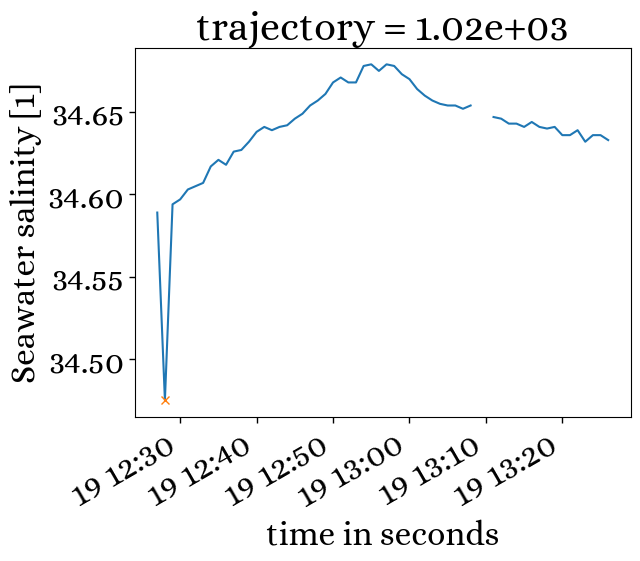

In [368]:
data[507:507+60].plot()
plt.plot(data["time"][508],data[508],marker="x")

In [ ]:
np.abs((data[507:507+60] - data[507]).values) > 0.006

In [313]:
# Calculate time differences (dS)
data = ds20["SAL_RBR_MEAN"]
dS = np.diff(data)

# Calculate the threshold based on a percentile of dS
threshold = np.nanpercentile(np.abs(dS), 95)
lag = 5

spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
i = 0
while i < len(dS):
    if (dS[i] <= -threshold) & (len(np.where(dS[i:i+lag] >= threshold)[0]) > 0):
        # Check if time difference is less than negative threshold
        start_idx = i  # Start from the maximum possible index within the lag window

        # Find the maximum positive change within the lag window
        max_positive_change_idx = i + np.argmax(np.where(dS[i:i+lag] >= threshold)[0])
        end_idx = max_positive_change_idx+1  # End at the maximum positive change index

        spikes[start_idx+1:end_idx+1] = True  # Mark the spike region for removal
        i = max_positive_change_idx + 1  # Move to the next index after the spike region
    else:
        i += 1  # Move to the next index

cleaned_data = data.copy()
cleaned_data[spikes] = np.nan  # Adjust for the difference in dimensions

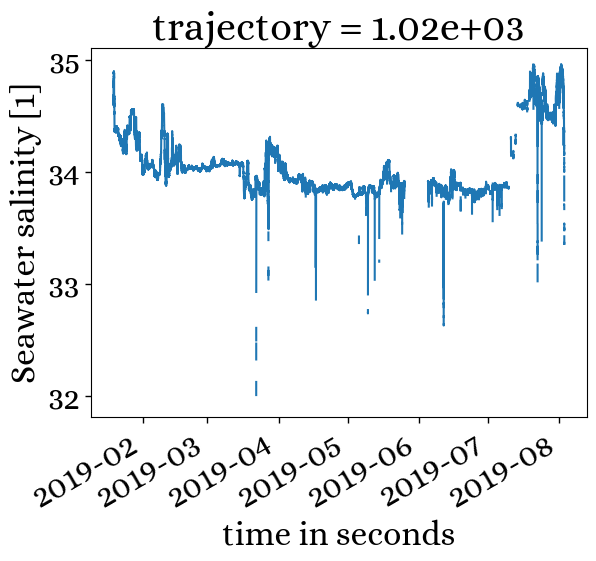

In [314]:
cleaned_data.plot()

In [286]:
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 60, 99).sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).plot()

ValueError: attempt to get argmax of an empty sequence

In [238]:
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 5, 99).sel(time="2019-04-17 05").diff("time") > threshold

<xarray.DataArray 'SAL_RBR_MEAN' (time: 59)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True, False,
        True, False, False, False, False])
Coordinates:
    latitude    (time) float64 ...
    longitude   (time) float64 ...
  * time        (time) datetime64[ns] 2019-04-17T05:01:00 ... 2019-04-17T05:5...
    trajectory  float32 1.02e+03

[Text(0.5, 0, ''), Text(0.5, 1.0, '')]

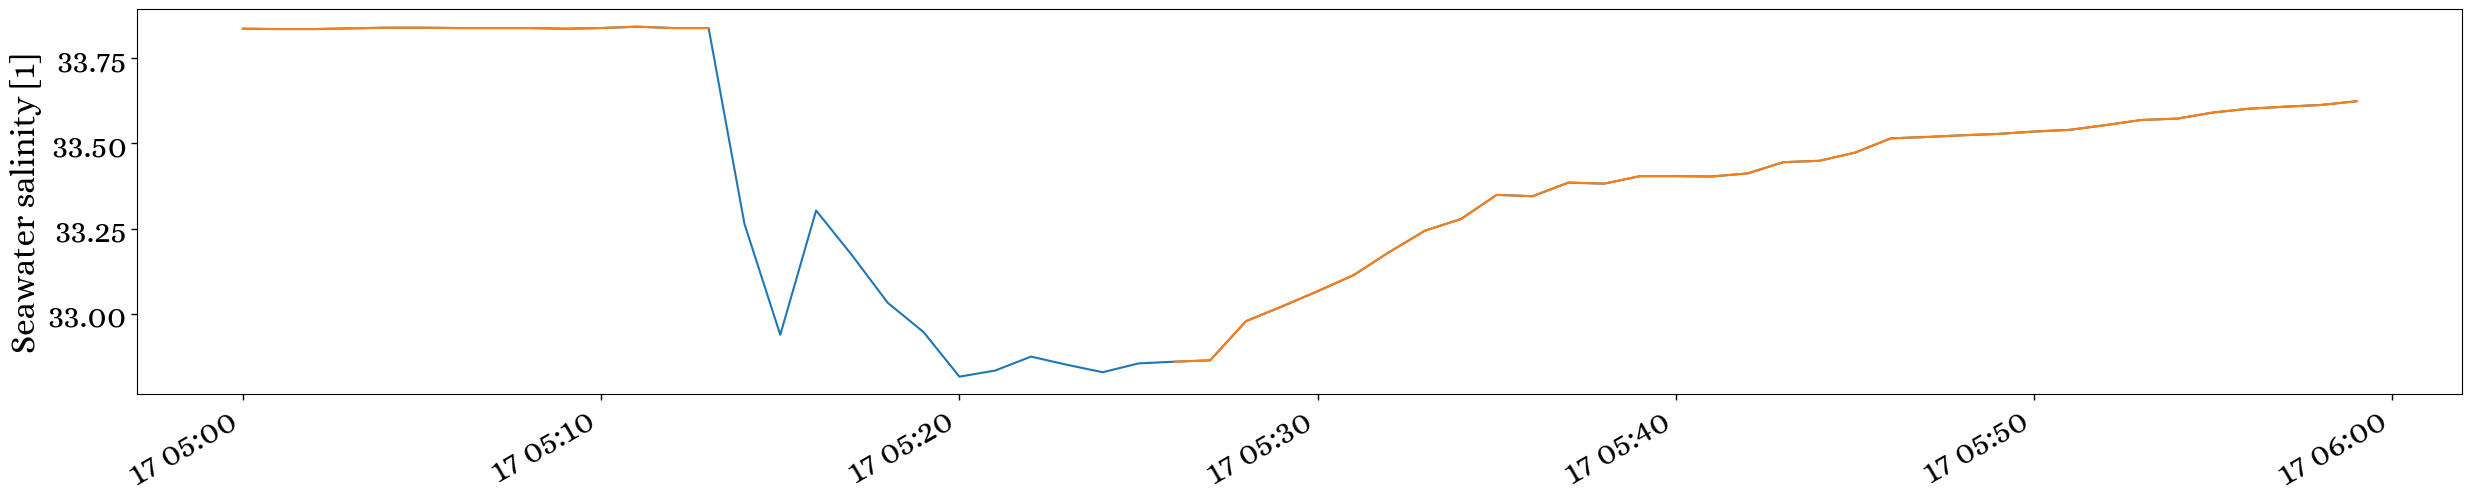

In [320]:
fig,ax = plt.subplots(figsize=(30,5))
ds20["SAL_RBR_MEAN"].sel(time="2019-04-17 05").plot()
#detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 5, 99).sel(time="2019-04-17 05").interpolate_na("time").plot()
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 5, 95).sel(time="2019-04-17 05").plot()
ax.set(xlabel="",title="")
# detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 15, 95).sel(time="2019-04-17 05").plot()

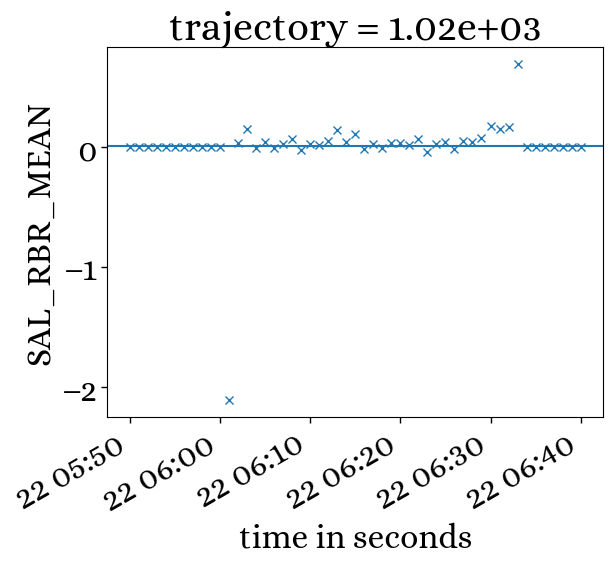

In [234]:
ds20["SAL_RBR_MEAN"].diff("time").sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).plot(marker='x',ls="")
plt.axhline(np.nanpercentile(ds20["SAL_RBR_MEAN"].diff("time"),95))

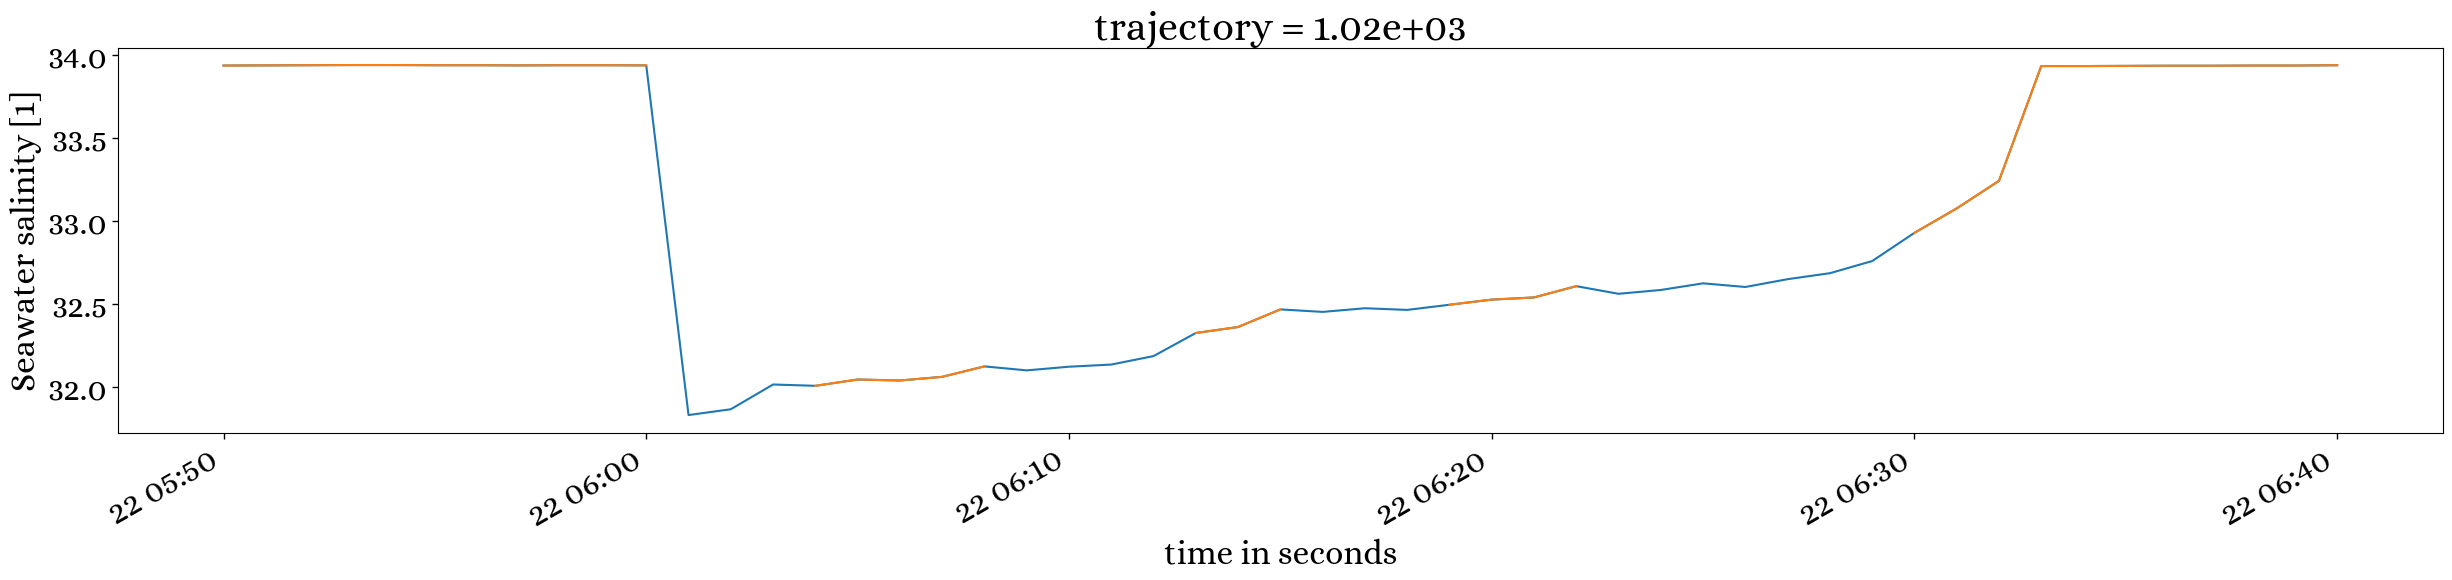

In [322]:
fig,ax = plt.subplots(figsize=(30,5))
ds20["SAL_RBR_MEAN"].sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).plot()
# detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 60, 95).sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).interpolate_na("time").plot()
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 5, 95).sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).plot()
# detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 15, 95).sel(time="2019-04-17 05").plot()

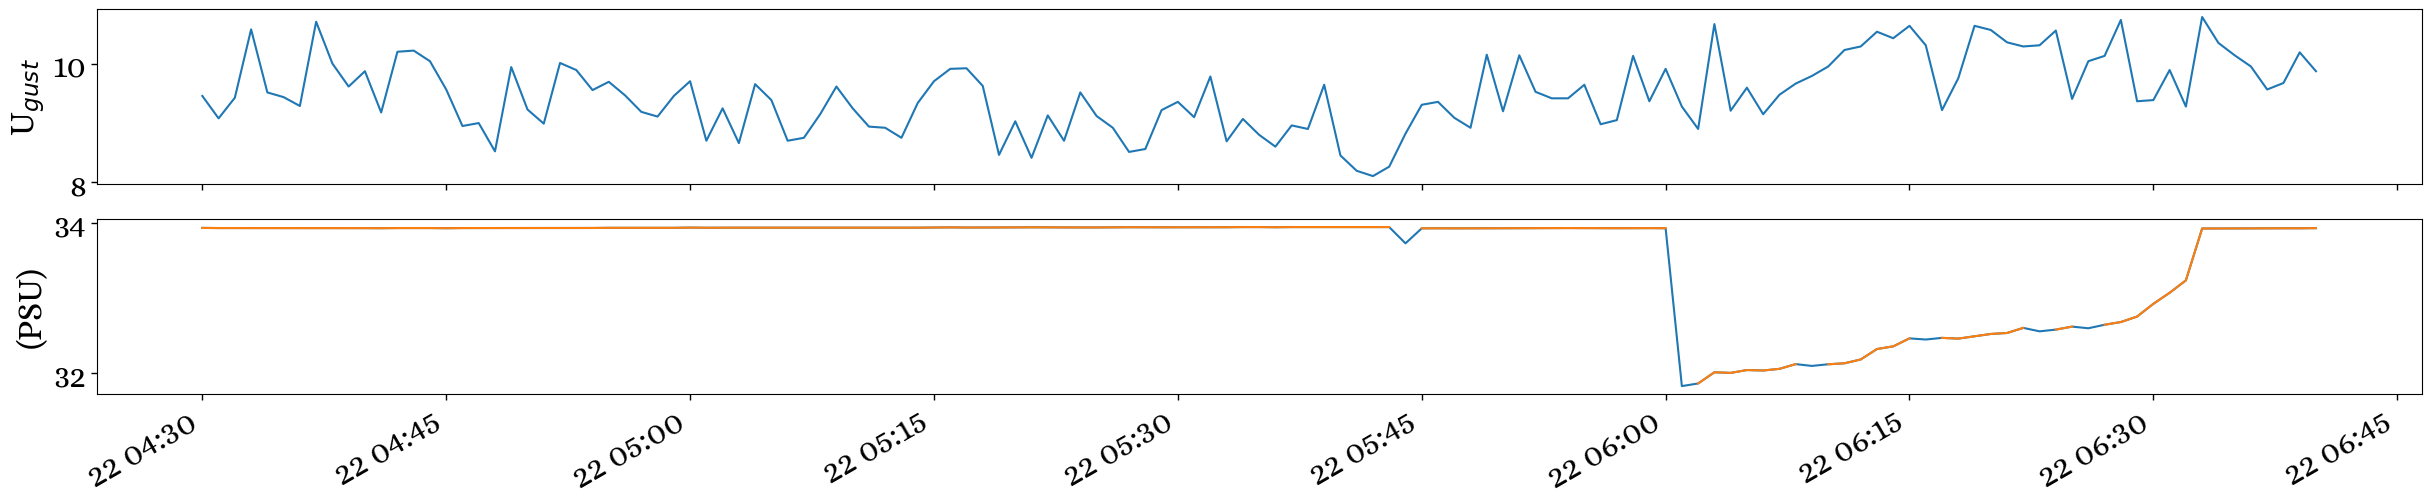

In [332]:
fig,ax = plt.subplots(2,1,figsize=(30,5),sharex=True)

ds20["GUST_WND_MEAN"].sel(time=slice("2019-03-22 04:30","2019-03-22 06:40")).plot(ax=ax[0])

ds20["SAL_RBR_MEAN"].sel(time=slice("2019-03-22 04:30","2019-03-22 06:40")).plot(ax=ax[1])
# detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 60, 95).sel(time=slice("2019-03-22 05:50","2019-03-22 06:40")).interpolate_na("time").plot()
detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 2, 99).sel(time=slice("2019-03-22 04:30","2019-03-22 06:40")).plot(ax=ax[1])
# detect_spikes_with_lag(ds20["SAL_RBR_MEAN"], 15, 95).sel(time="2019-04-17 05").plot()

for axs,y in zip(ax,[r"U$_{gust}$", "(PSU)"]):
    axs.set(title="",xlabel="",ylabel=y)

In [133]:
spikes = np.zeros(len(dS) + 1, dtype=bool)  # Extend the spikes array by one element
for i in range(len(dS)):
    if (dS[i] < -threshold) & (True in (dS[i:i+lag] > threshold)): # Check if time difference is less than negative threshold and that there is an upspike within the allowed interval
        start_idx = i  # Start from the maximum possible index within the lag window
        end_idx = i + np.where((dS[i:i+lag] > threshold) == True)[0][0]  # End at the current index
        spikes[start_idx:end_idx] = True  # Mark the spike region for removal

In [128]:
for i in range(len(dS)):
    if (dS[i] < -threshold) & (True in (dS[i:i+5] > threshold)):
        print(i,"Start of spike")
        print(i+np.where((dS[i:i+5] > threshold) == True)[0][0],"End of spike")
        

2 Start of spike
5 End of spike


In [141]:
# Example usage
salinity = np.array([35, 35, 33, 33, 35, 33, 35, 35], dtype=float)  # Example salinity data
dS = np.diff(salinity)  # Compute time difference of salinity
threshold = 1#np.percentile(dS, 95)  # Calculate the 95th percentile of dS
lag = 5  # Lag window size

spikes_with_lag = detect_spikes_with_lag(dS, lag, 1)
print("Spike indices with lag:", np.where(spikes_with_lag)[0])

# Output cleaned salinity array
cleaned_salinity = salinity.copy()
cleaned_salinity[np.concatenate(([False], spikes_with_lag))] = np.nan  # Adjust for the difference in dimensions
print("Cleaned salinity:", cleaned_salinity)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7 but corresponding boolean dimension is 8

In [106]:
dS

array([ 0.,  0., -2.,  0.,  0.,  2.,  0.])

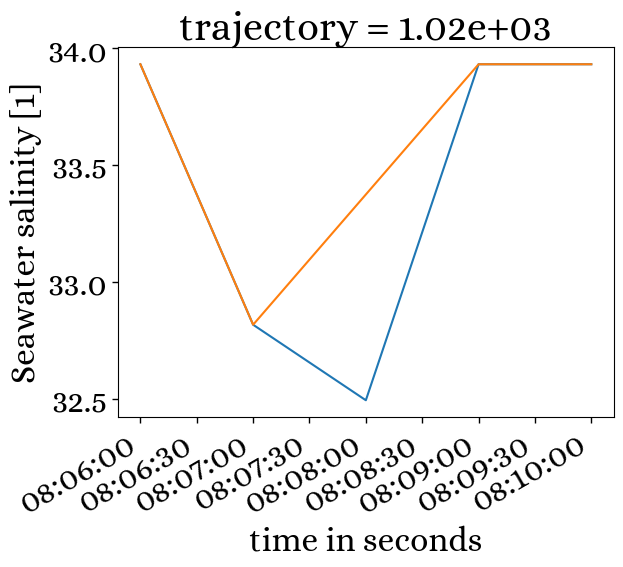

In [70]:
ds20["SAL_RBR_MEAN"].sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).plot()
qc_salinity(ds20,"SAL_RBR_MEAN",95,1).sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).plot()

In [58]:
one   = qc_salinity(ds20,"SAL_RBR_MEAN",95)
two   = qc_salinity(one,"SAL_RBR_MEAN",95)
three = qc_salinity(two,"SAL_RBR_MEAN",95)
four  = qc_salinity(three,"SAL_RBR_MEAN",95)
five  = qc_salinity(four,"SAL_RBR_MEAN",95)

KeyError: 'SAL_RBR_MEAN'

In [57]:
ds20

<xarray.Dataset>
Dimensions:                         (time: 282271)
Coordinates:
    latitude                        (time) float64 ...
    longitude                       (time) float64 ...
  * time                            (time) datetime64[ns] 2019-01-19T04:00:00...
    trajectory                      float32 1.02e+03
Data variables: (12/49)
    SOG                             (time) float64 1.762 1.361 ... 3.646 3.824
    COG                             (time) float64 119.8 118.8 ... 318.2 314.0
    HDG                             (time) float64 108.2 104.8 ... 317.3 312.8
    HDG_WING                        (time) float64 107.1 103.7 ... 107.3 107.3
    WING_ANGLE                      (time) float64 -1.1 -1.1 0.0 ... 147.8 151.5
    UWND_MEAN                       (time) float64 13.7 nan nan ... nan nan nan
    ...                              ...
    O2_SAT_RBR_MEAN                 (time) float64 96.29 96.24 ... 96.11 96.05
    O2_SAT_RBR_STDDEV               (time) float64 0.09 0.04 0.04 ... 0.07 0.09
    TEMP_O2_RBR_MEAN                (time) float64 15.68 15.67 ... 9.876 9.871
    TEMP_O2_RBR_STDDEV              (time) float64 0.002 0.002 ... 0.006 0.012
    CHLOR_RBR_MEAN                  (time) float64 1.505 1.534 ... 69.34 52.6
    CHLOR_RBR_STDDEV                (time) float64 0.0268 0.1127 ... 1.73 1.385
Attributes: (12/38)
    title:                     Antarctica Circumnavigation Surface Data
    summary:                   This data set was collected from the first Sai...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east

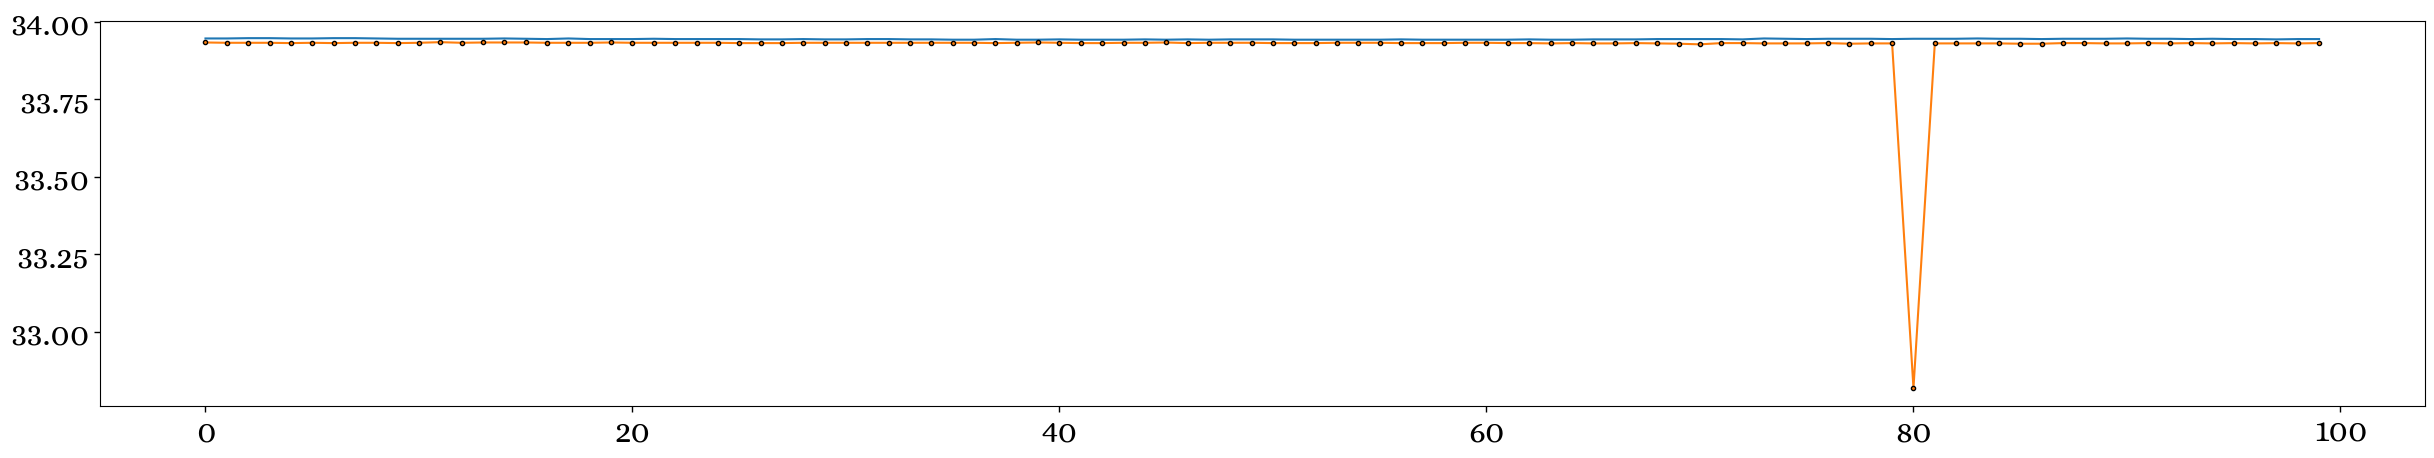

In [34]:
#ds20["SAL_RBR_MEAN"][:100000].plot()
plt.figure(figsize=(30,5))
plt.plot(ds20["SAL_RBR_MEAN"][27300:27400].values)
plt.plot(ds20["SAL_RBR_MEAN"][idx][27300:27400].values,marker='.',mec='k')

TypeError: No numeric data to plot.

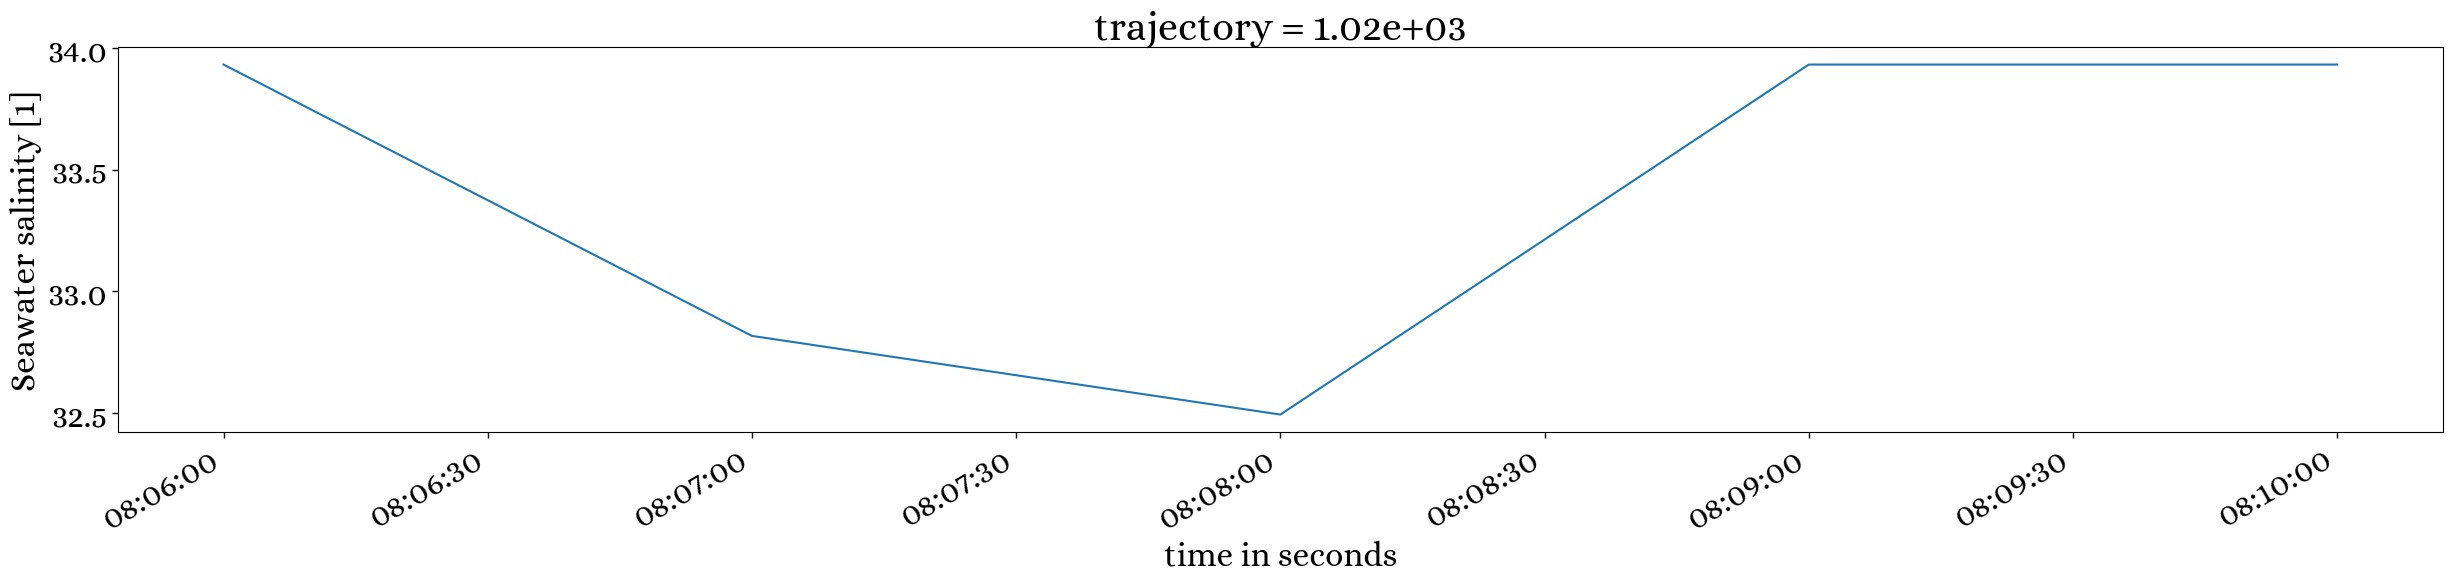

In [59]:
plt.figure(figsize=(30,5))
ds20["SAL_RBR_MEAN"].sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).plot()
ds20["SAL_RBR_MEAN"][idx].sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).resample(time="1min").mean("time").interpolate_na("time").plot()

In [ ]:
def qc_salinity(ds,variable,percentile):
    
    dS = np.diff(ds[variable])
    lim = np.nanpercentile(dS,percentile)
    bad = np.abs(ds) > lim
    idx = np.where(~((ds[:-1] < 0) & (ds[1:] > 0) & (bad[1:])))[0]+1
    
    
    

In [43]:
ds20["SAL_RBR_MEAN"].sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).values

array([33.931, 32.817, 32.494, 33.931, 33.931])

In [54]:
ds20["SAL_RBR_MEAN"][idx].sel(time=slice("2019-02-07 08:06","2019-02-07 08:10")).resample(time="1min").mean("time").interpolate_na("time").values

array([33.931, 32.817, 33.374, 33.931, 33.931])

In [60]:
def find_spike_indices(ds, variable, percentile):
    dS = np.diff(ds[variable])
    lim = np.nanpercentile(dS, percentile)
    bad = np.abs(dS) > lim
    
    spike_indices = []
    start_idx = None
    
    for i in range(len(dS)):
        if bad[i]:
            if start_idx is None:
                start_idx = i
        elif start_idx is not None:
            spike_indices.append(start_idx + 1)  # Adding 1 to account for np.diff()
            start_idx = None
    
    if start_idx is not None:
        spike_indices.append(start_idx + 1)  # Adding 1 to account for np.diff() for the last spike
    
    return spike_indices

idx = find_spike_indices(ds20, "SAL_RBR_MEAN", 95)
#print("Spike indices:", idx)

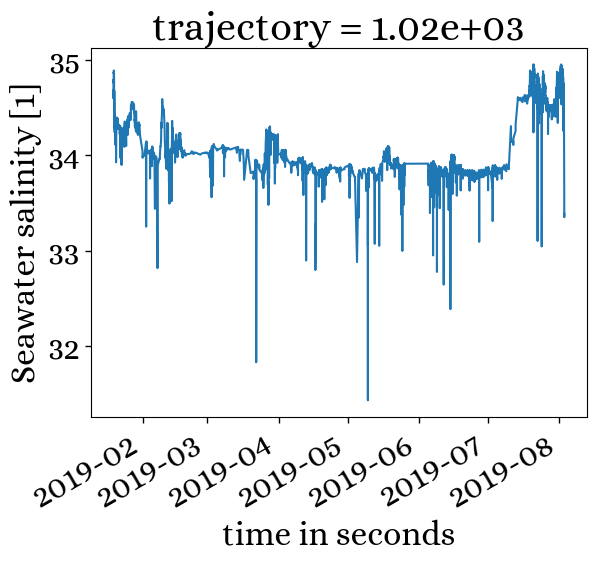

In [63]:
ds20["SAL_RBR_MEAN"][idx].plot()

In [64]:
def find_spike_indices(ds, variable, percentile):
    dS = np.diff(ds[variable])
    lim = np.nanpercentile(dS, percentile)
    bad = np.abs(dS) > lim
    #idx = np.where(~((dS[:-1] < 0) & (dS[1:] > 0) & (bad[1:])))[0] + 1
    
    spike_indices = []
    start_idx = None
    
    for i, val in enumerate(idx):
        if start_idx is None:
            start_idx = val
        elif len(spike_indices) == 0 or val - spike_indices[-1] > 1:
            spike_indices.append(start_idx)
            start_idx = val
        elif i == len(idx) - 1:
            spike_indices.append(start_idx)
        else:
            continue
    
    return spike_indices

idx = find_spike_indices(ds20, "SAL_RBR_MEAN", 95)
#print("Spike indices:", idx)

In [76]:
import numpy as np

def detect_spikes(data, threshold):
    """
    Detect spikes in a time series data based on a threshold.
    
    Parameters:
        data (ndarray): 1D array of the time series data.
        threshold (float): Threshold for detecting spikes.
    
    Returns:
        ndarray: Boolean array indicating spike locations.
    """
    differences = np.diff(data)
    sign_changes = np.sign(differences[:-1]) != np.sign(differences[1:])
    return np.abs(differences[1:]) > threshold, sign_changes

def remove_spikes(data, spikes, sign_changes):
    """
    Remove spikes from the time series data.
    
    Parameters:
        data (ndarray): 1D array of the time series data.
        spikes (ndarray): Boolean array indicating spike locations.
        sign_changes (ndarray): Boolean array indicating sign changes.
    
    Returns:
        ndarray: Cleaned time series data with spikes removed.
    """
    cleaned_data = data.copy()
    # Iterate over the spikes and remove the corresponding values if there's a sign change
    for i in range(len(spikes)):
        if spikes[i] and sign_changes[i]:
            cleaned_data[i+1] = np.nan  # Set the spike value to NaN
    return cleaned_data

In [78]:
# Example usage
salinity = np.array([33.931, 30, 30, 33.931, 33.931])
threshold = 1.0  # Adjust the threshold as needed

spikes, sign_changes = detect_spikes(salinity, threshold)
cleaned_salinity = remove_spikes(salinity, spikes, sign_changes, threshold)

print("Spike indices:", np.where(spikes)[0])
print("Raw salinity:", salinity)
print("Cleaned salinity:", cleaned_salinity)


Spike indices: [1]
Raw salinity: [33.931 30.    30.    33.931 33.931]
Cleaned salinity: [   nan    nan 30.    33.931 33.931]


In [79]:
ds

array([ 0.02 , -0.008, -0.004, ...,  0.001, -0.039,  0.043])

In [80]:
idx = np.where(~((ds[:-1] < 0) & (ds[1:] > 0) & (bad[1:])))[0]+1

In [83]:
idx[:10]

array([ 1,  2,  4,  5,  6,  8,  9, 10, 12, 13])

In [84]:
ds[:10]

array([ 0.02 , -0.008, -0.004,  0.015, -0.004,  0.006, -0.004,  0.009,
       -0.008, -0.015])

In [85]:
ds20["SAL_RBR_MEAN"].values[:10]

array([34.656, 34.676, 34.668, 34.664, 34.679, 34.675, 34.681, 34.677,
       34.686, 34.678])

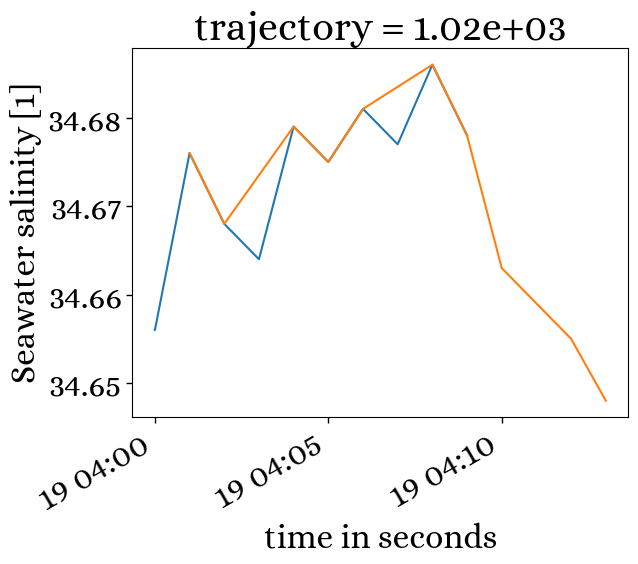

In [88]:
ds20["SAL_RBR_MEAN"][:10].plot()
ds20["SAL_RBR_MEAN"][idx][:10].plot()

In [89]:
xr.open_dataset("/Users/xedhjo/Downloads/103076.nc")

<xarray.Dataset>
Dimensions:    (station: 66, pressure: 6000)
Coordinates:
  * station    (station) int64 1 2 3 4 6 7 8 9 10 ... 62 63 65 66 72 74 78 80 82
  * pressure   (pressure) float64 0.0 1.0 2.0 ... 5.997e+03 5.998e+03 5.999e+03
Data variables:
    Longitude  (station) float64 ...
    Latitude   (station) float64 ...
    time       (station) datetime64[ns] ...
    TEMP       (station, pressure) float64 ...
    PSAL       (station, pressure) float64 ...
    O2         (station, pressure) float64 ...
    Chla       (station, pressure) float64 ...

In [90]:
data = xr.open_mfdataset('/Users/xedhjo/Documents/Projects/saildrone/sd-1067/daily_files/1min/saildrone*.nc',combine='nested', concat_dim='obs').load().squeeze().swap_dims({'obs':'time'})

/Users/xedhjo/opt/miniconda3/envs/env/lib/python3.11/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [96]:
data["INSTRUMENT_STATE"] = data.INSTRUMENT_STATE.astype(str)

In [98]:
data.to_netcdf("/Users/xedhjo/Documents/Projects/saildrone/data/SD-1067-NRT.nc")

In [238]:
data = xr.open_dataset("/Users/xedhjo/Documents/Projects/saildrone/data/SD-1067-NRT.nc")

In [245]:
data

<xarray.Dataset>
Dimensions:                                   (time: 131040)
Coordinates:
    latitude                                  (time) float64 -41.63 ... -34.07
    longitude                                 (time) float64 10.42 ... 16.31
  * time                                      (time) datetime64[ns] 2022-08-2...
    trajectory                                float32 ...
Data variables: (12/104)
    SOG                                       (time) float64 ...
    SOG_FILTERED_MEAN                         (time) float64 ...
    SOG_FILTERED_STDDEV                       (time) float64 ...
    SOG_FILTERED_MAX                          (time) float64 ...
    SOG_FILTERED_MIN                          (time) float64 ...
    COG                                       (time) float64 ...
    ...                                        ...
    O2_CONC_SBE37_MEAN                        (time) float64 ...
    O2_CONC_SBE37_STDDEV                      (time) float64 ...
    O2_SAT_SBE37_MEAN                         (time) float64 ...
    O2_SAT_SBE37_STDDEV                       (time) float64 ...
    CHLOR_WETLABS_MEAN                        (time) float64 ...
    CHLOR_WETLABS_STDDEV                      (time) float64 ...
Attributes: (12/40)
    title:                     SOCHIC_SO_Saildrone_NRT_data
    summary:                   Southern Ocean heat and carbon study. Subantar...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.2
    featureType:               trajectory
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        7.951872
    geospatial_lon_max:        18.9176048
    geospatial_lon_units:      degrees_east
    pi_name:                   Sebastiaan Swart
    project_infoUrl:           www.sochic-h2020.eu

In [241]:
from datetime import date
data.attrs["title"]                = "SOCHIC_SO_Saildrone_NRT_data"
data.attrs["summary"]              = "Southern Ocean heat and carbon study. Subantarctic to subtropical south Atlantic."
data.attrs["creator_name"]         = "Johan Edholm"
data.attrs["creator_email"]        = "johan.edholm@gu.se"
data.attrs["creator_url"]          = "https://polargliders.com"
data.attrs["institution"]          = "University of Gothenburg"
data.attrs["pi_name"]              = "Sebastiaan Swart"
data.attrs["project"]              = "SO-CHIC"
data.attrs["project_infoUrl"]      = "www.sochic-h2020.eu"

data.attrs['date_created']           = str(date.today())
data.attrs['time_coverage_start']    = str(data.time[0].values)
data.attrs['time_coverage_end']      = str(data.time[-1].values)
data.attrs['time_coverage_duration'] = str((data.time[-1].values - data.time[0].values).astype('timedelta64[D]')+1)
data.attrs['geospatial_lat_min']     = str(data.latitude.min().values)
data.attrs['geospatial_lat_max']     = str(data.latitude.max().values)
data.attrs['geospatial_lon_min']     = str(data.longitude.min().values)
data.attrs['geospatial_lon_max']     = str(data.longitude.max().values)

In [246]:
data.to_netcdf("/Users/xedhjo/Documents/Projects/saildrone/data/SD-1067-NRT-data_2.nc")

In [228]:
sb = xr.open_dataset("/Users/xedhjo/Downloads/SB_20220110_SOCHIC.nc")
sg640 = xr.open_dataset("/Users/xedhjo/Downloads/SG640_20220110_SOCHIC.nc")
sg675 = xr.open_dataset("/Users/xedhjo/Downloads/SG675_20220123_SOCHIC.nc")

In [235]:
for data in [sb,sg640,sg675]:
    data.attrs["creator_name"]         = "Johan Edholm"
    data.attrs["creator_email"]        = "johan.edholm@gu.se"
    data.attrs["creator_url"]          = "https://polargliders.com"
    data.attrs["institution"]          = "University of Gothenburg"
    data.attrs["pi_name"]              = "Sebastiaan Swart"
    data.attrs["project"]              = "SO-CHIC"
    data.attrs["project_infoUrl"]      = "www.sochic-h2020.eu"

In [237]:
sb.to_netcdf("/Users/xedhjo/Downloads/SB_20220110_SOCHIC_2.nc")
sg640.to_netcdf("/Users/xedhjo/Downloads/SG640_20220110_SOCHIC_2.nc")
sg675.to_netcdf("/Users/xedhjo/Downloads/SG675_20220123_SOCHIC_2.nc")

In [222]:
data.to_netcdf("/Users/xedhjo/Downloads/SG675_20220123_SOCHIC_2.nc")

In [ ]:
data.attrs["title"]                = "SOCHIC_SO_Saildrone_NRT_data"
data.attrs["summary"]              = "Southern Ocean heat and carbon study. Subantarctic to subtropical south Atlantic."
data.attrs["creator_name"]         = "Johan Edholm"
data.attrs["creator_email"]        = "johan.edholm@gu.se"
data.attrs["creator_url"]          = "https://polargliders.com"
data.attrs["institution"]          = "University of Gothenburg"
data.attrs["pi_name"]              = "Sebastiaan Swart"
data.attrs["project"]              = "SO-CHIC"
data.attrs["project_infoUrl"]      = "www.sochic-h2020.eu"

data.attrs['date_created']           = str(date.today())
data.attrs['time_coverage_start']    = str(data.time[0].values)
data.attrs['time_coverage_end']      = str(data.time[-1].values)
data.attrs['time_coverage_duration'] = str((data.time[-1].values - data.time[0].values).astype('timedelta64[D]')+1)
data.attrs['geospatial_lat_min']     = str(data.latitude.min().values)
data.attrs['geospatial_lat_max']     = str(data.latitude.max().values)
data.attrs['geospatial_lon_min']     = str(data.longitude.min().values)
data.attrs['geospatial_lon_max']     = str(data.longitude.max().values)

In [36]:
data.interp(time=np.arange("2022-08-24 00:00:00","2022-11-22 23:59:00",2,dtype="datetime64[m]"),)

<xarray.Dataset>
Dimensions:                                   (time: 65520)
Coordinates:
    latitude                                  (time) float64 -41.63 ... -34.07
    longitude                                 (time) float64 10.42 ... 16.31
    trajectory                                float32 1.067e+03
  * time                                      (time) datetime64[ns] 2022-08-2...
Data variables: (12/104)
    SOG                                       (time) float64 0.808 ... 0.56
    SOG_FILTERED_MEAN                         (time) float64 0.856 ... 0.505
    SOG_FILTERED_STDDEV                       (time) float64 0.33 ... 0.235
    SOG_FILTERED_MAX                          (time) float64 1.56 ... 1.008
    SOG_FILTERED_MIN                          (time) float64 0.105 ... 0.095
    COG                                       (time) float64 299.5 ... 152.9
    ...                                        ...
    O2_CONC_SBE37_STDDEV                      (time) float64 0.21 nan ... nan
    O2_SAT_SBE37_MEAN                         (time) float64 96.34 nan ... nan
    O2_SAT_SBE37_STDDEV                       (time) float64 0.08 nan ... nan
    CHLOR_WETLABS_MEAN                        (time) float64 nan nan ... 3.78
    CHLOR_WETLABS_STDDEV                      (time) float64 nan nan ... 3.5
    INSTRUMENT_STATE                          (time) object 'None' ... 'None'
Attributes: (12/40)
    title:                     SO-CHIC 2022 NRT Surface Data
    summary:                   Southern Ocean heat and carbon study. Subantar...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.2
    featureType:               trajectory
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        10.006752
    geospatial_lon_max:        10.418968
    geospatial_lon_units:      degrees_east
    pi_name:                   Sebastiaan Swart
    project_infoUrl:           www.sochic-h2020.eu

In [100]:
adcp = xr.open_mfdataset('/Users/xedhjo/Documents/Projects/saildrone/sd-1067/daily_files/adcp/*.nc',combine='nested', concat_dim='obs').load().squeeze().swap_dims({'obs':'time'})

In [101]:
adcp

<xarray.Dataset>
Dimensions:              (time: 6080, cell_depth: 50, beam: 4)
Coordinates:
    trajectory           float32 1.067e+03
  * time                 (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-1...
    latitude             (time) float64 -41.03 -41.05 -41.06 ... -34.07 -34.07
    longitude            (time) float64 10.76 10.77 10.77 ... 16.3 16.3 16.3
  * cell_depth           (cell_depth) float64 4.2 6.2 8.2 ... 98.2 100.2 102.2
Dimensions without coordinates: beam
Data variables: (12/28)
    roll                 (time) float64 -1.846 -3.642 -3.768 ... -0.8789 -0.824
    pitch                (time) float64 -0.5219 -0.5603 ... -0.5548 -0.5219
    heading              (time) float64 142.1 130.5 112.8 ... 260.4 258.5 269.3
    vel_east             (time, cell_depth) float64 0.047 0.063 ... 0.126 0.173
    vel_north            (time, cell_depth) float64 -0.057 -0.053 ... -0.089
    vel_up               (time, cell_depth) float64 -0.032 -0.039 ... -0.058
    ...                   ...
    bt_vel_up            (time) float64 nan nan nan nan nan ... nan nan nan nan
    bt_amp               (time, beam) float64 nan nan nan nan ... nan nan nan
    bt_percent_good      (time, beam) float64 nan nan nan nan ... nan nan nan
    percent_good_4_beam  (time, cell_depth) float64 71.0 90.0 97.0 ... 43.0 4.0
    percent_good_3_beam  (time, cell_depth) float64 19.0 9.0 3.0 ... 37.0 29.0
    percent_good         (time, cell_depth) float64 90.0 99.0 ... 80.0 33.0
Attributes: (12/37)
    description:                     Saildrone NetCDF Format
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        ADCP,Saildrone
    geospatial_vertical_units:       meters
    geospatial_lon_units:            degrees_east
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lat_min:              -41.06701271608472
    geospatial_lat_max:              -41.05748366564512
    geospatial_lon_min:              10.773571450263262
    geospatial_lon_max:              10.779201951809227
    geospatial_vertical_positive:    down
    license:                         2022 (C) SAILDRONE Inc.  All Rights Rese...

In [45]:
data

<xarray.Dataset>
Dimensions:                                   (time: 131040)
Coordinates:
    latitude                                  (time) float64 -41.63 ... -34.07
    longitude                                 (time) float64 10.42 ... 16.31
  * time                                      (time) datetime64[ns] 2022-08-2...
    trajectory                                float32 ...
Data variables: (12/104)
    SOG                                       (time) float64 ...
    SOG_FILTERED_MEAN                         (time) float64 ...
    SOG_FILTERED_STDDEV                       (time) float64 ...
    SOG_FILTERED_MAX                          (time) float64 ...
    SOG_FILTERED_MIN                          (time) float64 ...
    COG                                       (time) float64 ...
    ...                                        ...
    O2_CONC_SBE37_MEAN                        (time) float64 ...
    O2_CONC_SBE37_STDDEV                      (time) float64 ...
    O2_SAT_SBE37_MEAN                         (time) float64 ...
    O2_SAT_SBE37_STDDEV                       (time) float64 ...
    CHLOR_WETLABS_MEAN                        (time) float64 ...
    CHLOR_WETLABS_STDDEV                      (time) float64 ...
Attributes: (12/40)
    title:                     SO-CHIC 2022 NRT Surface Data
    summary:                   Southern Ocean heat and carbon study. Subantar...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.2
    featureType:               trajectory
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        7.951872
    geospatial_lon_max:        18.9176048
    geospatial_lon_units:      degrees_east
    pi_name:                   Sebastiaan Swart
    project_infoUrl:           www.sochic-h2020.eu